In [1]:
import numpy as np
import scipy
import asyncio, time
import pandas as pd
from queue import LifoQueue
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from tqdm import tqdm
pd.set_option('display.max_columns', 1000)
np.set_printoptions(precision=4, suppress=True)
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, auc, roc_auc_score

In [2]:
class Node(object):
    def __init__(self, parent, num_samples, is_left=False):
        self.parent = parent
        self.left_child = None
        self.right_child = None
        self.is_left = None
        self.weight = None
        self.split_feature = None
        self.split_val = None
        self.sparse_dir_left = None
        self.num_samples = num_samples

    @property
    def is_leaf(self):
        return not bool(self.left_child) and not bool(self.right_child)
    
    def calculate_weight(self, gradient, hessian, lmbd):
        if isinstance(hessian, np.ndarray):
            hessian[hessian == 0.] += 1e-8
        return np.sum(gradient)/(np.sum(hessian) + lmbd)
    
    def calculate_quality(self, G, H, lmbd):
        if isinstance(H, np.ndarray):
            H[H == 0.] += 1e-8
        return np.square(G)/(H + lmbd)
    
    def calculate_gain(self, G, H, G_l, H_l, G_r, H_r, lmbd):
        return self.calculate_quality(G_l, H_l, lmbd) +\
                self.calculate_quality(G_r, H_r, lmbd) - \
                self.calculate_quality(G, H, lmbd)
    
    def find_split(self, data, data_idx, lmbd, num_featuress=None, min_samples_leaf=1, eps=0.3, approximate=False):
        feature_idx = data.sample_features(num_featuress)
        G_node, H_node = data.get_gradient_hessian(data_idx)

        # get a mtrix with n_features x n_points with gains for sorted feature values
        # gradient_matrix = data.get_gradient_matrix(feature_idx, data_idx, aproximate)
        # hessian_matrix = data.get_hessian_matrix(feature_idx, data_idx, aproximate)
        # split_value_matrix = data.get_split_value_matrix(feature_idx, data_idx, aproximate)
        # print (data_idx)
        if min_samples_leaf > len(data_idx)/2:
            return None, None, None
        if not approximate:
            gradient_matrix, hessian_matrix, split_value_matrix = data.get_GHS_matrices(feature_idx, data_idx, approximate)
        if approximate:
            gradient_matrix, hessian_matrix, split_value_matrix, num_samples_matrix = \
                data.get_GHS_matrices_approx(feature_idx, data_idx, eps)
        G_l_matrix = np.nancumsum(gradient_matrix, axis=1)
        H_l_matrix = np.nancumsum(hessian_matrix, axis=1)
        G_l_matrix[np.isnan(gradient_matrix)] = np.nan
        

        gain_matrix = self.calculate_gain(G_node, H_node, 
                                          G_l_matrix, H_l_matrix, 
                                          G_node - G_l_matrix, H_node - H_l_matrix,
                                          lmbd)
        
        # removing splits that may result in less than min_samples_leaf in either child
        if not approximate:
            gain_matrix = np.hstack([gain_matrix[:, min_samples_leaf - 1: -min_samples_leaf], gain_matrix[:, -1:]])
            if min_samples_leaf > 1:
                split_value_matrix = np.hstack([split_value_matrix[:, min_samples_leaf - 1: 1 - min_samples_leaf]])
        else:
            num_samples_matrix = np.nancumsum(num_samples_matrix, axis=1)
            last_col = gain_matrix[:, -1:].copy()
            gain_matrix[num_samples_matrix < min_samples_leaf] = np.nan
            # last_col = gain_matrix[:, -1:]
            gain_matrix[-1*(num_samples_matrix - num_samples_matrix[:, -1:]) < min_samples_leaf] = np.nan
            gain_matrix[:, -1:] = last_col
        
        # print (gain_matrix)
        best_split = np.unravel_index(np.nanargmax(gain_matrix), shape=gain_matrix.shape)
        # print (feature_idx[best_split[0]], best_split[1])
        if not approximate and best_split[1] >= len(data_idx) - (2 * min_samples_leaf) + 2 - 1:
            return None, None, None
        elif approximate and best_split[1] >= gain_matrix.shape[1] - 1:
            return None, None, None
        # find the value of feature split from split_index
        split_dir = True
        if best_split[0] >= len(feature_idx):
            split_dir = False ## nans go right
        
        return feature_idx[best_split[0] % len(feature_idx)], split_value_matrix[best_split], split_dir
    
    def predict(self, X, idx, verbose=False):
        if self.is_leaf:
            if verbose: print ('leaf:', self.weight, 'num_samples:', self.num_samples)
            return self.weight
        else:
            # print (idx)
            if verbose: print('idx:',idx)
            out = np.zeros(len(idx), dtype='float')
            # split_left_right = X[idx, self.split_feature] < self.split_val
            
            split_left_right = np.logical_or(X[idx, self.split_feature] < self.split_val, 
                                       np.isnan(X[idx, self.split_feature]) & self.sparse_dir_left)
            left_idx = idx[split_left_right]
            if verbose: print ('left:', left_idx)
            right_idx = idx[~(split_left_right)]
            if verbose: print ('right:',right_idx)
            out_left_idx = np.where(split_left_right)[0]
            out_right_idx = np.where(~(split_left_right))[0]

            if verbose: print("left ->")
            out[out_left_idx] = self.left_child.predict(X, left_idx, verbose)
            if verbose: print ("right ->")
            out[out_right_idx] = self.right_child.predict(X, right_idx, verbose)
            if verbose: print (out, 'outidx', out_left_idx, out_right_idx, 'num_samples:', self.num_samples)
            return out

class Tree(object):
    def __init__(self, obj='sq_error', max_depth=4, num_features=None, min_samples_leaf=1, eps=0.3):
        self.residuals = None
        self.hessians = None
        self.root = None
        self.max_depth = max_depth
        self.num_features = num_features
        self.min_samples_leaf = min_samples_leaf
        self.predictions = None
        self.obj = obj
        self.eps = eps

    def get_train_predictions(self):
        # if self.obj == "sq_error":
            return self.predictions
        # elif self.obj == 'bin_logistic':
        #     return 1.0/(1.0 + np.exp(-1.0 * self.predictions))
    
    def update_data_vars(self, data_obj):
        data_obj.update_residuals_hessians(self.residuals, self.hessians)

    def grow_tree(self, data, gradients, hessians, lmbd, approximate=False):
        self.residuals = gradients
        self.hessians = hessians
        self.predictions = np.zeros_like(self.residuals)
        self.update_data_vars(data_obj=data)
        self.root = Node(None, data.num_samples)
        depth = 0
        node_stack = LifoQueue()
        self.root.weight = self.root.calculate_weight(gradients, hessians, lmbd)
        node_stack.put((self.root, depth, np.arange(data.num_samples)))
        while (not node_stack.empty()):
            node, depth, data_idx = node_stack.get()
            if depth < self.max_depth:
                left_data_idx, right_data_idx = \
                    self.split_node(node, data, data_idx, lmbd, approximate)
                # print (left_data_idx, right_data_idx)
                if node.is_leaf and left_data_idx is None: # leaf node
                    self.predictions[data_idx] = node.weight
                else:
                    node.left_child.weight = node.left_child.calculate_weight(data.residuals[left_data_idx], 
                                                                            data.hessians[left_data_idx], lmbd)
                    node.right_child.weight = node.right_child.calculate_weight(data.residuals[right_data_idx], 
                                                                            data.hessians[right_data_idx], lmbd)
                    node_stack.put((node.left_child, depth + 1, left_data_idx))
                    node_stack.put((node.right_child, depth + 1, right_data_idx))
            else: #leaf node
                self.predictions[data_idx] = node.weight

    def split_node(self, node, data, data_idx, lmbd, approximate=False):
        split_feature, split_value, split_dir = node.find_split(data, data_idx, 
                                                     lmbd, self.num_features, 
                                                     min_samples_leaf=self.min_samples_leaf, 
                                                     eps=self.eps,
                                                     approximate=approximate)
        if split_feature is None:
            return None, None
        node.split_feature =  split_feature
        node.split_val = split_value
        node.sparse_dir_left = split_dir
        # split_data_idx = data.X[data_idx, split_feature] < split_value
        split_data_idx = np.logical_or(data.X[data_idx, split_feature] < split_value, 
                                       np.isnan(data.X[data_idx, split_feature]) & split_dir)
        node.left_child = Node(node, split_data_idx.sum(), is_left=True)
        node.right_child = Node(node, data_idx.shape[0] - split_data_idx.sum())
        return data_idx[split_data_idx], data_idx[~split_data_idx]
    
    def predict(self, X, verbose=False):
        idx = np.arange(X.shape[0])
        return self.root.predict(X, idx, verbose)


class XGBoost(object):
    def __init__(self, obj='sq_error', # or 'logistic'
                 n_estimators=100, lmbd=0, eta=0.3, 
                 max_depth=4, min_samples_leaf=1,
                 num_features=None, eps=0.3, approximate=False,
                 case_weights=None):
        self.n_estimators = n_estimators
        self.eta = eta
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.num_features = num_features
        self.approximate = approximate
        self.lmbd = lmbd
        self.learners = []
        self.obj = obj
        self.eps = eps
        self.case_weights = case_weights if case_weights is not None else 1.0

    def __call__(self):
        pass

    def __repr__(self) -> str:
        return self.__class__.__name__ + " n_estimators: " + str(self.n_estimators)

    def train(self, data, verbose=True):
        losses = []
        self.learners = []
        predictions = np.zeros((data.num_samples,))
        for i in tqdm(range(self.n_estimators)):
            gradients, hessians = self.calculate_gradients(predictions, data)
            learner = Tree(obj=self.obj, 
                           max_depth=self.max_depth, 
                           num_features=self.num_features,
                           min_samples_leaf=self.min_samples_leaf,
                           eps=self.eps)
            learner.grow_tree(data, gradients, hessians, self.lmbd, approximate=self.approximate)
            predictions += self.eta * learner.get_train_predictions()
            self.learners.append(learner)

            ## validate 
            train_loss = self.loss(data.y, predictions)
            losses.append(train_loss)
            if verbose:
                print ("Training loss:", train_loss)
        return losses

    def predict(self, X):
        return self.eta * sum([l.predict(X) for l in self.learners])
    
    def sigmoid(self, X):
        return 1.0/(1.0 + np.exp(-1.0 * X))
    
    def loss(self, y, preds):
        if self.obj == 'sq_error':
            return np.mean(np.square(y - preds))
        elif self.obj == 'logistic':
            preds = self.sigmoid(preds)
            return -1 * np.mean((y * np.log(preds)) + ((1 - y) * np.log(1 - preds)))
    
    def validate(self, X, y):
        preds = self.predict(X)
        preds = np.where(preds > 1.0e-10, preds, 1.0e-10)
        return self.loss(y, preds)
    
    def calculate_gradients(self, predictions, data):
        if self.obj == 'sq_error':
            residuals = (data.y - predictions) * self.case_weights
            hessian = np.ones(data.y.shape[0]) * self.case_weights
        elif self.obj == 'logistic':
            probs = self.sigmoid(predictions)
            residuals = (data.y - probs) * self.case_weights
            hessian = probs * (1.0 - probs) * self.case_weights
        return residuals, hessian


class Data(object):
    # holds columns in sorted orders to reduce 
    # cost of sorting each time 
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.data = []
        self.sort_features(self.X)
        self.residuals = None
        self.hessians = None

    @property
    def num_samples(self):
        return self.X.shape[0]
    
    def sample_features(self, num_features):
        if num_features:
            return np.random.choice(np.arange(self.X.shape[1]), num_features, replace=False)
        else:
            return np.random.choice(np.arange(self.X.shape[1]), self.X.shape[1], replace=False)
    
    def sort_features(self, X):
        self.sorted_idx = np.argsort(X, axis=0)
        self.nan_idx = {f_id: set(np.where(np.isnan(X[:, f_id]))[0]) for f_id in range(X.shape[1])}

    def update_residuals_hessians(self, residuals, hessians):
        self.residuals = residuals
        self.hessians = hessians
    
    def get_GHS_matrices(self, feature_idx, data_idx, eps, aproximate=False):
        # may add multiprocessing here
        data_idx = set(data_idx)
        grad_matrix = np.zeros((len(feature_idx) * 2, len(data_idx)))
        grad_matrix[:, :] = np.nan
        
        hess_matrix = np.zeros((len(feature_idx) * 2, len(data_idx)))
        split_val_matrix = np.zeros((len(feature_idx) * 2, len(data_idx) - 1))
        for i, f_id in enumerate(feature_idx):
            grad_row = []
            hess_row = []
            split_val_row = []
            idx_nan = []
            mask = np.in1d(self.sorted_idx[:, f_id], list(data_idx))
            sorted_idx = self.sorted_idx[mask, f_id]
            # for d_id in self.sorted_idx[:, f_id]:
            for d_id in sorted_idx:
                if d_id in data_idx:
                    if d_id in self.nan_idx.get(f_id, {}):
                        idx_nan.append(d_id)
                    else:
                        grad_row.append(self.residuals[d_id])
                        hess_row.append(self.hessians[d_id])
                        split_val_row.append(self.X[d_id, f_id])
            
            if len(idx_nan) == 0:
                grad_matrix[i] = np.array(grad_row, dtype='float')
                hess_matrix[i] = np.array(hess_row, dtype='float')
                split_val_row_a = np.array(split_val_row, dtype='float')
                split_val_matrix[i] = (split_val_row_a[:-1] + split_val_row_a[1:])/2
            else:
                grad_matrix[len(feature_idx) + i] = np.array(grad_row + [None] * len(idx_nan), dtype='float')
                hess_matrix[len(feature_idx) + i] = np.array(hess_row + [None] * len(idx_nan), dtype='float')
                split_val_row_a = np.array(split_val_row + [None] * len(idx_nan), dtype='float')
                split_val_matrix[len(feature_idx) + i] = (split_val_row_a[:-1] + split_val_row_a[1:])/2

                if len(grad_row) > 0:
                    grad_row[0] += self.residuals[idx_nan].sum()
                    hess_row[0] += self.hessians[idx_nan].sum()
                grad_matrix[i] = np.array([None] * len(idx_nan) + grad_row, dtype='float')
                hess_matrix[i] = np.array([None] * len(idx_nan) + hess_row, dtype='float')
                split_val_row_a = np.array([None] * len(idx_nan) + split_val_row, dtype='float')
                split_val_matrix[i] = (split_val_row_a[:-1] + split_val_row_a[1:])/2

        if np.sum(~np.isnan(grad_matrix[len(feature_idx):])) == 0:
            return grad_matrix[:len(feature_idx)], hess_matrix[:len(feature_idx)], split_val_matrix[:len(feature_idx)]
        
        return grad_matrix, hess_matrix, split_val_matrix
    
    def get_GHS_matrices_approx(self, feature_idx, data_idx, eps):
        data_idx = set(data_idx)
        # grad_matrix = np.zeros((len(feature_idx) * 2, len(data_idx)))
        grad_matrix = []
        # grad_matrix[:, :] = np.nan
        
        # hess_matrix = np.zeros((len(feature_idx) * 2, len(data_idx)))
        hess_matrix = []
        # split_val_matrix = np.zeros((len(feature_idx) * 2, len(data_idx) - 1))
        split_val_matrix = []
        num_samples_matrix = []
        idx_nan_list = []
        max_width = -1
        total_weight = self.hessians[list(data_idx)].sum()
        for i, f_id in enumerate(feature_idx):
            # total_weight = self.hessians[list(data_idx - self.nan_idx.get(f_id, {}))].sum()
            total_weight_f = total_weight - self.hessians[list(data_idx.intersection(self.nan_idx.get(f_id, {})))].sum()
            # print ('*'*100, total_weight_f)
            grad_row, hess_row, split_val_row, idx_nan, num_samples_row = \
                self.get_GHS_row_approx(data_idx, f_id, eps * total_weight_f)
            grad_matrix.append(grad_row)
            hess_matrix.append(hess_row)
            split_val_matrix.append(split_val_row)
            num_samples_matrix.append(num_samples_row)
            idx_nan_list.append(idx_nan)
            max_width = max(max_width, len(hess_row))
        grad_matrix = np.array([[None] * (max_width - len(grad_row)) + grad_row \
                                for grad_row in grad_matrix], 
                               dtype='float')
        hess_matrix = np.array([[None] * (max_width - len(hess_row)) + hess_row \
                                for hess_row in hess_matrix], 
                               dtype='float')
        split_val_matrix = np.array([[None] * (max_width - len(split_val_row)) + split_val_row \
                                     for split_val_row in split_val_matrix], 
                                    dtype='float')
        num_samples_matrix = np.array([[None] * (max_width - len(num_samples_row)) + num_samples_row \
                                       for num_samples_row in num_samples_matrix], 
                                      dtype='float')
        r_grad_matrix = np.zeros_like(grad_matrix)
        r_grad_matrix[:, :] = np.nan

        r_hess_matrix = np.zeros_like(hess_matrix)
        r_num_samples_matrix = np.zeros_like(num_samples_matrix)

        for i, idx_nan in enumerate(idx_nan_list):
            if len(idx_nan) != 0 and int(np.isnan(grad_matrix[i]).sum()) < grad_matrix.shape[1]:
                r_grad_matrix[i] = grad_matrix[i].copy()
                r_hess_matrix[i] = hess_matrix[i].copy()
                r_num_samples_matrix[i] = num_samples_matrix[i].copy()

                grad_matrix[i, int(np.isnan(grad_matrix[i]).sum())] += self.residuals[idx_nan].sum()
                hess_matrix[i, int(np.isnan(hess_matrix[i]).sum())] += self.hessians[idx_nan].sum()
                num_samples_matrix[i, int(np.isnan(num_samples_matrix[i]).sum())] += len(idx_nan)

        if np.sum(~np.isnan(grad_matrix[len(feature_idx):])) != 0:
            return (np.vstack([grad_matrix, r_grad_matrix]), 
                    np.vstack([hess_matrix, r_hess_matrix]), 
                    np.vstack([split_val_matrix, split_val_matrix]),
                    np.vstack([num_samples_matrix, r_num_samples_matrix]))
        
        return grad_matrix, hess_matrix, split_val_matrix, num_samples_matrix
    
    def get_GHS_row_approx(self, data_idx, f_id, eps):
        grad_row = []
        hess_row = []
        split_val_row = []
        num_samples = []
        idx_nan = []
        h_current = 0.0
        g_current = 0.0
        ns_current = 0
        mask = np.in1d(self.sorted_idx[:, f_id], list(data_idx))
        sorted_idx = self.sorted_idx[mask, f_id]
        # for d_id in self.sorted_idx[:, f_id]:
        for d_id in sorted_idx:
            if d_id in data_idx:
                if d_id in self.nan_idx.get(f_id, {}):
                    idx_nan.append(d_id)
                else:
                    if h_current + self.hessians[d_id] < eps or ns_current <= 0:
                        h_current += self.hessians[d_id]
                        g_current += self.residuals[d_id]
                        ns_current += 1
                    else:
                        hess_row.append(h_current)
                        grad_row.append(g_current)
                        split_val_row.append(self.X[d_id, f_id])
                        num_samples.append(ns_current)
                        h_current = self.hessians[d_id]
                        g_current = self.residuals[d_id]
                        ns_current = 1
        if h_current > 0.0:
            grad_row.append(g_current)
            hess_row.append(h_current)
            num_samples.append(ns_current)
        return grad_row, hess_row, split_val_row, idx_nan, num_samples
    
    def get_gradient_hessian(self, data_idx):
        return self.residuals[data_idx].sum(), self.hessians[data_idx].sum()
    
    def get_gradient_matrix(self, feature_idx, data_idx, aproximate=False):
        # may add multiprocessing here
        grad_matrix = np.zeros(len(feature_idx), len(data_idx))
        for i, f_id in enumerate(feature_idx):
            grad_matrix[i] = np.array([self.residuals[d_id] for d_id in self.sorted_idx[:, f_id] if d_id in data_idx])
        return grad_matrix
    
    def get_hessian_matrix(self, feature_idx, data_idx, aproximate=False):
        # may add multiprocessing here
        hess_matrix = np.zeros(len(feature_idx), len(data_idx))
        for i, f_id in enumerate(feature_idx):
            hess_matrix[i] = np.array([self.hessians[d_id] for d_id in self.sorted_idx[:, f_id] if d_id in data_idx])
        return hess_matrix
    
    def get_split_value_matrix(self, feature_idx, data_idx, aproximate=False):
        # may add multiprocessing here
        split_val_matrix = np.zeros(len(feature_idx), len(data_idx) - 1)
        for i, f_id in enumerate(feature_idx):
            split_val_row = np.array([self.X[d_id, f_id] for d_id in self.sorted_idx[:, f_id] if d_id in data_idx])
            split_val_matrix[i] = (split_val_row[1:] + split_val_row[:-1])/2
        return split_val_matrix

In [48]:
mask = np.in1d(data.sorted_idx[:, 16], a)

# Use the boolean mask to filter elements
data.sorted_idx[mask, 16]

array([131977, 131974,    916, 131982,    883,   2323, 131968, 131964,
          885, 131980, 131959,    907,     43,   2918,    670])

In [86]:
mask = np.in1d(data.sorted_idx[:, 16], a)
sorted_idx = data.sorted_idx[mask, 16]
print (sorted_idx)

[131977 131974    916 131982    883   2323 131968 131964    885 131980
 131959    907     43   2918    670]


In [88]:
sorted_idx.dtype

dtype('int64')

In [45]:
[i for i in data.sorted_idx[:, 16] if i in a]

[131977,
 131974,
 916,
 131982,
 883,
 2323,
 131968,
 131964,
 885,
 131980,
 131959,
 907,
 43,
 2918,
 670]

In [43]:
np.intersect1d(data.sorted_idx[:, 16], a, return_indices=True)

(array([    43,    670,    883,    885,    907,    916,   2323,   2918,
        131959, 131964, 131968, 131974, 131977, 131980, 131982]),
 array([135373, 193857,  74410,  98313, 127258,  25399,  75201, 147388,
        123422,  88597,  86349,  20417,   7937, 120367,  41015]),
 array([11, 12,  0,  1,  7, 10, 14, 13,  2,  3,  4,  5,  6,  8,  9]))

In [85]:
a = [883,
 885,
 131959,
 131964,
 131968,
 131974,
 131977,
 907,
 131980,
 131982,
 916,
 43,
 670,
 2918,
 2323]
a

[883,
 885,
 131959,
 131964,
 131968,
 131974,
 131977,
 907,
 131980,
 131982,
 916,
 43,
 670,
 2918,
 2323]

In [29]:
2323 in data.nan_idx[0]

True

In [30]:
set(a) - data.nan_idx[0]

{43, 670, 2918, 97868768678}

In [601]:
from collections import OrderedDict
d = OrderedDict()
d.update({'a':2, 'b':1})
sorted(d, key=d.get)
np.argsort(a, axis=0)

np.random.seed(10)
a = np.random.randint(0, 100, (5,4))
print (a)
c = np.sort(a, axis=0)
print (c)
b = np.argsort(a, axis=0)
print (b)


[[ 9 15 64 28]
 [89 93 29  8]
 [73  0 40 36]
 [16 11 54 88]
 [62 33 72 78]]
[[ 9  0 29  8]
 [16 11 40 28]
 [62 15 54 36]
 [73 33 64 78]
 [89 93 72 88]]
[[0 2 1 1]
 [3 3 2 0]
 [4 0 3 2]
 [2 4 0 4]
 [1 1 4 3]]


In [284]:
d = np.array([1,4,3])
z = a[d, 2]
print (z)
# z[np.nonzero(z > 3)]
d[np.nonzero(z > 50)[0]]

[29 72 54]


array([4, 3])

In [612]:
a[:, 1:3], a[:, -0:]

(array([[15, 64],
        [93, 29],
        [ 0, 40],
        [11, 54],
        [33, 72]]),
 array([[ 9, 15, 64, 28],
        [89, 93, 29,  8],
        [73,  0, 40, 36],
        [16, 11, 54, 88],
        [62, 33, 72, 78]]))

In [611]:
np.hstack([a[:, 1:2], a[:, -1:]])

array([[15, 28],
       [93,  8],
       [ 0, 36],
       [11, 88],
       [33, 78]])

In [28]:
a = np.arange(8).reshape(4,2)
print (np.cumsum(a, axis=1))
b = np.unravel_index(np.argmax(np.cumsum(a, axis=1)), shape=a.shape)
np.cumsum(a, axis=1)[b]

[[ 0  1]
 [ 2  5]
 [ 4  9]
 [ 6 13]]


13

In [127]:
q = LifoQueue()
q.put({'a':1})
q.put({'b': 2})
q.empty()
print (q.get())
print (q.get())
q.empty()

{'b': 2}
{'a': 1}


True

In [319]:
len(a[0])

4

In [109]:
tree = Tree()

In [482]:
root = Node(None, 10)
root.weight = 5
root.split_feature = 0
root.split_val = 10

node = Node(root, 10)
root.left_child = node
node.is_left = True
node.split_feature = 0
node.split_val = 0
node.weight = 10

node = Node(root, 10)
root.right_child = node
node.split_feature = 0
node.split_val = 10
node.weight = 0

node = Node(root.left_child, 10)
root.left_child.left_child = node
node.is_left = True
node.split_feature = 0
node.split_val = 15
node.weight = -5

node = Node(root.left_child, 10)
root.left_child.right_child = node
node.split_feature = 0
node.split_val = 20
node.weight = -10


In [483]:
X = np.random.randint(-20,20, (20,1))
X

array([[  2],
       [  8],
       [ 17],
       [-12],
       [  4],
       [  8],
       [ -4],
       [ -2],
       [ 11],
       [ 17],
       [  8],
       [-17],
       [ 11],
       [ 11],
       [-18],
       [  9],
       [ -5],
       [ 17],
       [ 19],
       [  4]])

In [484]:
root.right_child.is_leaf

True

In [485]:
bool(root.left_child)

True

In [486]:
root.predict(X, np.arange(20))

array([-10, -10,   0,  -5, -10, -10,  -5,  -5,   0,   0, -10,  -5,   0,
         0,  -5, -10,  -5,   0,   0, -10])

In [487]:
X.flatten()

array([  2,   8,  17, -12,   4,   8,  -4,  -2,  11,  17,   8, -17,  11,
        11, -18,   9,  -5,  17,  19,   4])

In [279]:
np.argmax(np.array([1,2,np.nan, 4]))
np.array([1,2,np.nan, 4])

array([ 1.,  2., nan,  4.])

In [3]:
sample_data_X = np.vstack([np.random.normal(loc=[1, 0, 1], scale=1, size=[50,3]),
                        #  np.random.normal(loc=[0, 0, 1], scale=1, size=[50,3]),
                         np.random.normal(loc=[1, 1, 0], scale=1, size=[50,3])])

sample_data_X.shape

(100, 3)

In [6]:
sample_data_X[[1, 10, 45,46],0] = None
sample_data_X

array([[ 0.108 ,  2.0436,  1.3503],
       [    nan, -0.6485,  3.572 ],
       [ 1.7176,  0.334 ,  2.199 ],
       [ 0.3369,  0.217 ,  1.9998],
       [ 0.713 ,  1.7651,  2.646 ],
       [ 1.9525, -0.1409, -0.8261],
       [ 2.4098, -2.2405, -0.8362],
       [ 3.0149, -1.2141,  1.8378],
       [-0.577 ,  0.6285,  2.4798],
       [ 2.3119,  1.4148,  1.6463],
       [    nan, -0.0502,  0.9063],
       [ 1.0186, -0.5541,  1.3848],
       [ 0.0663, -0.0132, -1.6362],
       [ 0.1253, -0.0857, -2.0698],
       [ 1.3354,  1.1687,  2.8449],
       [-0.4515,  0.6233,  3.3122],
       [-0.2171,  1.9201,  2.1917],
       [ 1.5883,  0.0779,  1.5873],
       [ 0.6808,  2.1942, -2.6294],
       [ 1.7827,  0.2223,  0.8937],
       [ 0.4868, -0.9694,  2.0587],
       [ 0.847 ,  0.5058,  0.4985],
       [ 0.1695,  2.4744,  1.5827],
       [ 0.4005, -0.3463,  0.1308],
       [-0.6683,  1.7457,  0.2636],
       [ 2.5714,  0.1089,  1.5766],
       [ 1.1039,  0.6911,  1.9961],
       [ 1.841 ,  0.5688,  0

In [7]:
# sample_data_y = np.array([0]*50 + [1]*50 + [2]*50)
sample_data_y = np.array([0]*50 + [1]*50)

sample_data_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [8]:
data = Data(sample_data_X, sample_data_y)
data.X.shape

(100, 3)

In [9]:
data.nan_idx

{0: {1, 10, 45, 46}, 1: set(), 2: set()}

In [140]:
xgb = XGBoost(obj='logistic', eta=0.3, max_depth=4, min_samples_leaf=4, approximate=True, eps=0.01)

In [141]:
t_loss = xgb.train(data, verbose=False)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 355.89it/s]


Text(0, 0.5, 'Loss')

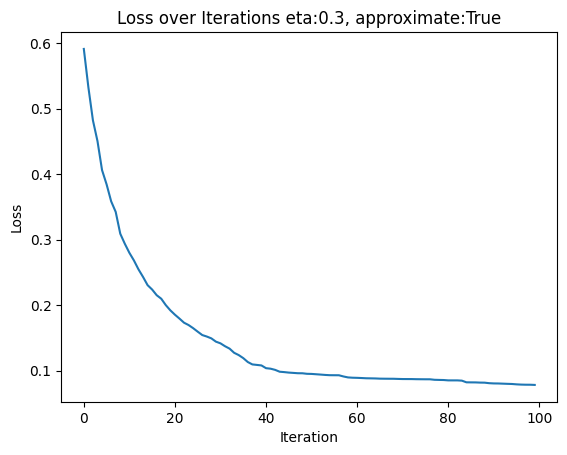

In [142]:
plt.plot(np.arange(len(t_loss)), t_loss)
plt.title("Loss over Iterations eta:{}, approximate:{}".format(xgb.eta, xgb.approximate))
plt.xlabel("Iteration")
plt.ylabel("Loss")

In [143]:
preds = xgb.sigmoid(xgb.predict(data.X))

In [144]:
np.set_printoptions(precision=4, suppress=True)
print (preds)

[0.1863 0.     0.1431 0.1019 0.0007 0.0368 0.1017 0.0001 0.     0.0004
 0.     0.104  0.0564 0.0507 0.0039 0.     0.0067 0.0123 0.0439 0.1409
 0.0075 0.2534 0.0023 0.2037 0.2793 0.0113 0.0399 0.1466 0.0371 0.0244
 0.1996 0.0083 0.0595 0.1151 0.     0.0002 0.0093 0.1976 0.0149 0.0026
 0.0001 0.0214 0.2551 0.4931 0.0669 0.     0.0001 0.0001 0.0001 0.0112
 0.9913 0.9795 0.8221 0.9996 0.9943 0.7149 0.9993 0.912  0.9865 0.9929
 0.9996 0.917  0.9887 0.974  0.8614 0.9836 0.9893 0.95   0.9774 0.8876
 0.8227 0.9955 0.8523 0.9237 0.9942 0.9931 0.8925 0.9823 0.6694 0.9881
 0.8815 0.9909 0.9938 0.9828 0.9903 0.4931 0.9644 0.9653 0.9703 0.9944
 0.8747 0.9284 0.9814 0.9588 0.8768 0.9802 0.9999 0.8045 0.9961 0.8858]


In [145]:

log_loss(data.y, preds)

0.07840193453740497

In [146]:
np.sqrt(((preds - data.y)**2).mean())

0.12014870716288793

In [147]:
data.X[[1,2], 1]

array([-0.6485,  0.334 ])

In [148]:
sample_test_X = np.vstack([np.random.normal(loc=[1, 0, 1], scale=1, size=[50,3]),
                        #  np.random.normal(loc=[0, 0, 1], scale=1, size=[50,3]),
                         np.random.normal(loc=[1, 1, 0], scale=1, size=[50,3])])

sample_test_X.shape

(100, 3)

In [149]:
sample_test_y = np.array([0]*50 + [1]*50)

sample_test_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [150]:
xgb.validate(sample_test_X, sample_test_y)

0.9905057441912116

In [151]:
roc_auc_score(sample_data_y, xgb.predict(sample_data_X))

0.9998

In [152]:
roc_auc_score(sample_test_y, xgb.predict(sample_test_X))

0.6507999999999999

In [68]:
xgb.learners[0].predict(data.X[1:20], verbose=True)

idx: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
left: [ 4  5  9 11 12 17 18]
right: [ 0  1  2  3  6  7  8 10 13 14 15 16]
left ->
idx: [ 4  5  9 11 12 17 18]
left: [ 4  5  9 11 12 18]
right: [17]
left ->
idx: [ 4  5  9 11 12 18]
left: [9]
right: [ 4  5 11 12 18]
left ->
leaf: -2.0 num_samples: 3
right ->
idx: [ 4  5 11 12 18]
left: [11 12 18]
right: [4 5]
left ->
leaf: 0.2857142857142857 num_samples: 21
right ->
leaf: -0.5 num_samples: 8
[-0.5    -0.5     0.2857  0.2857  0.2857] outidx [2 3 4] [0 1] num_samples: 29
[-0.5    -0.5    -2.      0.2857  0.2857  0.2857] outidx [2] [0 1 3 4 5] num_samples: 32
right ->
idx: [17]
left: []
right: [17]
left ->
idx: []
left: []
right: []
left ->
leaf: -0.6666666666666666 num_samples: 3
right ->
leaf: 1.3333333333333333 num_samples: 6
[] outidx [] [] num_samples: 9
right ->
idx: [17]
left: []
right: [17]
left ->
leaf: 1.8181818181818181 num_samples: 22
right ->
leaf: 0.4 num_samples: 5
[0.4] outidx [] [0] num_samples: 27
[0.4] outid

array([-1.4286, -1.1111, -1.1111, -1.1111, -0.5   , -0.5   , -2.    ,
       -1.4286, -2.    , -2.    , -0.8571,  0.2857,  0.2857, -1.1111,
       -1.4286, -1.4286, -2.    ,  0.4   ,  0.2857])

In [875]:
xgb.learners[0].predictions[1:20]

array([0.8396, 0.8396, 0.8396, 0.8396, 1.2   , 0.8396, 0.8396, 0.8396,
       1.    , 0.8396, 0.8396, 0.8396, 0.5   , 0.8396, 0.8396, 0.8396,
       0.8396, 0.2   , 0.8396])

In [535]:
X = data.X[:4]
node = xgb.learners[0].root
idx = np.arange(4)
out = np.zeros(4)
split_lr = X[idx, node.split_feature] < node.split_val
left_idx = idx[split_lr]
right_idx = idx[~split_lr]
split_lr, left_idx, right_idx
# node = node.left_child
# X[left_idx, node.split_feature] < node.split_val
out_left_idx = np.where(split_lr)[0]
out_right_idx = np.where(~(split_lr))[0]
out_left_idx, out_right_idx
out[out_left_idx] = 10
out

array([ 0., 10.,  0., 10.])

In [1208]:
xgb.learners[0].root.left_child.right_child.left_child.left_child.weight

0.6666666666666666

In [69]:
x = data.X[1]
x

array([    nan, -0.6485,  3.572 ])

In [70]:
# should belong to class 0
node = xgb.learners[0].root
print ("root ->")
while(not node.is_leaf):
    if x[node.split_feature] < node.split_val:
        node = node.left_child
        print ("left -> ")
    else:
        node = node.right_child
        print ("right ->")
print (node.weight)

root ->
right ->
right ->
right ->
right ->
-1.1111111111111112


In [475]:
out = np.zeros(4)
out[] = 1
out

array([0., 0., 0., 0.])

In [1215]:
xgb.learners[0].predictions

array([-2.    ,  0.4   , -2.    , -2.    , -1.5556, -1.    ,  0.4   ,
       -2.    ,  1.2   , -0.1818,  0.6667, -2.    , -1.5556, -1.    ,
        0.4   , -2.    , -0.1818, -0.1818, -2.    , -2.    , -2.    ,
        1.4286, -0.6667, -1.5556, -2.    , -2.    , -1.    , -1.5556,
       -2.    , -1.5556, -1.5556,  1.    , -2.    , -0.6667, -0.1818,
       -0.1818,  0.4   , -0.6667, -2.    ,  1.7778, -2.    , -1.5556,
       -0.6667, -1.5556, -2.    ,  1.    , -2.    , -2.    , -0.1818,
       -2.    ,  1.2   , -0.1818,  1.4286,  1.7778,  0.4   ,  1.7778,
        1.    ,  1.7778,  1.7778,  1.7778,  1.2   , -0.1818,  1.2   ,
        1.7778,  0.6667,  1.    ,  1.7778,  1.7778,  1.7778,  1.4286,
        0.6667, -0.6667,  1.7778,  0.4   ,  0.4   ,  1.    , -1.5556,
        1.7778,  1.2   ,  0.4   ,  1.7778,  1.    , -0.6667,  1.7778,
        1.4286,  1.    ,  1.7778,  1.7778, -0.1818,  1.4286, -1.    ,
        1.4286,  1.7778, -0.1818,  1.    ,  0.4   ,  1.7778,  1.4286,
        0.4   , -0.1

In [398]:
a[a==9]=1
isinstance(a, np.ndarray)

True

In [750]:
a = a.astype('float')
a[1, 0] = np.nan
np.nanargmax(a,axis=1)
b = np.zeros((3,4))
b[:, :] = np.nan
b[2] = [7,6,3,9]
b[1] = [7,943,9,3]

In [936]:
b

array([[-100., -100., -100., -100.],
       [  nan,  943.,    9.,    3.],
       [  nan,    6.,    3.,    9.]])

In [938]:

np.unravel_index(np.nanargmax(b), b.shape)

(1, 1)

In [1023]:
nan_dir = True
a = np.arange(3)
print (b[1, :])
np.logical_or((b[1,:] < 100), np.isnan(b[1, :]) & nan_dir)

[ nan 943.   9.   3.]


array([ True, False,  True,  True])

In [800]:
~(np.bitwise_or((b[1,:] < 100), np.isnan(b[1, :]) & nan_dir))

array([False,  True, False, False])

In [367]:
data_idx = [int(x) for x in '2   6  11  13  18  34  36  39  40  56  80 109 110 113 115 128 135 136 137 140'.split()]
data_idx

[2,
 6,
 11,
 13,
 18,
 34,
 36,
 39,
 40,
 56,
 80,
 109,
 110,
 113,
 115,
 128,
 135,
 136,
 137,
 140]

In [359]:
data.get_GHS_matrices([])

array([1.69348047, 2.02794571, 2.72744767, 3.43520758])

In [650]:
xgb.learners[0].root.split_feature
xgb.learners[0].root.split_val
xgb.learners[0].root.right_child.right_child.right_child.num_samples

20

In [429]:
sum([xgb.learners[i].predictions for i in range(100)]) * 0.3

array([ 1.99424263e-02,  1.51019004e-02,  2.23897997e-02,  1.38395744e-02,
       -1.51901013e-02, -4.08843160e-03,  1.69698242e-03, -1.31630064e-02,
        1.92737589e-02,  1.29752198e-02,  1.79160140e-02,  1.00408582e-02,
       -2.33283225e-03,  1.56099034e-02,  8.09388237e-03,  2.11838350e-02,
        4.21129983e-02,  6.06914015e-03,  2.18248988e-02,  9.92297898e-03,
        1.90461962e-02,  5.09896437e-03,  1.02468146e-02,  1.24153526e-02,
        2.91647947e-02,  1.66863482e-02,  2.70403737e-02,  1.15890539e-02,
        7.01892948e-03,  2.51692048e-02,  1.59490663e-02,  2.22073289e-02,
       -1.16617876e-02, -2.13043193e-03, -2.20903024e-03,  8.38270882e-03,
        5.52774511e-03,  2.19319205e-02,  2.32123119e-02,  4.94196651e-03,
        6.03025612e-03,  1.22253994e-02,  2.78941540e-02,  3.27325901e-02,
        2.70022603e-02,  3.02879504e-02,  1.32377667e-02,  1.43297895e-02,
       -2.70281591e-03,  7.03360499e-03,  9.95687661e-01,  9.92727408e-01,
        9.94227940e-01,  

array([0.75013158, 1.66121795, 0.75013158, 1.66121795, 0.25539474,
       1.81564103, 1.66121795, 0.25539474, 2.48969298, 0.86099707,
       0.94473684, 0.25539474, 0.86099707, 0.93333333, 0.        ,
       0.25539474, 0.90013158, 1.66121795, 0.25539474, 0.25539474,
       1.2953405 , 0.86099707, 0.90013158, 0.25539474, 0.25539474,
       0.25539474, 0.94473684, 0.        , 0.25539474, 0.86099707,
       0.94473684, 0.        , 0.45      , 0.86099707, 0.25539474,
       0.86099707, 0.25539474, 0.25539474, 0.86099707, 0.86099707,
       0.25539474, 0.25539474, 0.86099707, 0.86099707, 0.        ,
       0.86099707, 0.25539474, 0.48230769, 0.86099707, 1.66121795,
       1.2953405 , 1.66121795, 1.42      , 1.66121795, 2.48969298,
       1.2953405 , 1.12828947, 1.66121795, 2.48969298, 0.86099707,
       1.66121795, 0.86099707, 1.66121795, 1.42      , 0.86099707,
       1.66121795, 1.2953405 , 2.48969298, 2.48969298, 0.86099707,
       1.66121795, 0.25539474, 1.66121795, 1.66121795, 1.48230

In [407]:
xgb.predict(data.X)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149]
[  5   8  10  13  14  26  27  30  31  44  47  54  58  67  68  74  78  82
  84  92  95  98 100 101 103 104 105 106 107 108 111 112 113 114 115 116
 118 119 120 121 122 127 128 129 131 132 134 135 136 137 138 139 140 142
 143 144 145 146 147 148 149]
[  8  10  13  14  26  27  30  31  44  47  54  58  67  68  78  92  95 105
 113 116 118 120 128 131 132 134 145 149]
[  8  10  26  30  54  58  

array([0. , 0. , 0. , 0. , 0. , 0.3, 0. , 0. , 0.6, 0. , 0. , 0. , 0. ,
       0.3, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0.6, 0. , 0.3, 0. , 0.6, 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0.6, 0.6, 0. , 0. , 0. , 0. , 0. , 0.3, 0. , 0. , 0. ,
       0.6, 0. , 0. , 0. , 0.6, 0. , 0.3, 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0.6, 0. , 0. , 0. , 0. , 0. , 0.6, 0. , 0.9, 0.6, 0.6, 0.9,
       0.6, 0.9, 0.9, 0.9, 0.9, 0. , 0.6, 0.9, 0.6, 0.6, 0.9, 0.9, 0.9,
       0.6, 0.9, 0.6, 0.9, 0.9, 0.6, 0.6, 0.6, 0.6, 0.9, 0.9, 0.6, 0.9,
       0.6, 0.9, 0.6, 0.9, 0.6, 0.6, 0.6, 0.9, 0.6, 0.6, 0.9, 0.9, 0.9,
       0.6, 0.9, 0.9, 0.6, 0.6, 0.6, 0.3])

In [481]:
a = np.arange(4)
a[np.where(np.array([1,2,3,4])<0)[0]] = 10
a

array([0, 1, 2, 3])

In [713]:
a

array([[ 9., 15., 64., 28.],
       [nan, 93., 29.,  8.],
       [73.,  0., 40., 36.],
       [16., 11., 54., 88.],
       [62., 33., 72., 78.]])

In [1142]:
d = [2.,1.]
c = [3.,4.,2.]
e = np.array([[None] * 1 + d, [None] * 0 + c], dtype='float')
e

array([[nan,  2.,  1.],
       [ 3.,  4.,  2.]])

In [1143]:
np.nancumsum(e, axis=1)

array([[0., 2., 3.],
       [3., 7., 9.]])

In [1144]:
e = np.nancumsum(e, axis=1)
-(e- e[:, -1:] )

array([[ 3.,  1., -0.],
       [ 6.,  2., -0.]])

## Higgs Boson Data

In [3]:
df = pd.read_csv("higgs-boson/training.csv")
df

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,197.760,1.582,1.396,0.2,32.638,1.017,0.381,51.626,2.273,-2.414,16.824,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,s
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,125.157,0.879,1.414,-999.0,42.014,2.039,-3.011,36.918,0.501,0.103,44.704,-1.916,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,b
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,197.814,3.776,1.414,-999.0,32.154,-0.705,-2.093,121.409,-0.953,1.052,54.283,-2.186,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,b
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,75.968,2.354,-1.285,-999.0,22.647,-1.655,0.010,53.321,-0.522,-3.100,31.082,0.060,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,5.446378,b
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,57.983,1.056,-1.385,-999.0,28.209,-2.197,-2.231,29.774,0.798,1.569,2.723,-0.871,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,349995,-999.000,71.989,36.548,5.042,-999.00,-999.000,-999.000,1.392,5.042,55.892,1.258,-1.414,-999.0,24.754,-0.414,-0.905,31.137,-0.950,0.380,46.520,2.859,144.665,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,4.505083,b
249996,349996,-999.000,58.179,68.083,22.439,-999.00,-999.000,-999.000,2.585,22.439,50.618,1.162,-1.345,-999.0,23.416,-1.609,2.776,27.202,0.308,1.042,46.737,-0.867,80.408,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,2.497259,b
249997,349997,105.457,60.526,75.839,39.757,-999.00,-999.000,-999.000,2.390,22.183,120.462,1.202,0.529,-999.0,35.636,-0.266,-3.132,42.834,0.381,0.851,23.419,-2.890,198.907,1,41.992,1.800,-0.166,-999.000,-999.00,-999.000,41.992,0.018636,s
249998,349998,94.951,19.362,68.812,13.504,-999.00,-999.000,-999.000,3.365,13.504,55.859,0.999,1.414,-999.0,27.944,-2.211,2.792,27.915,-0.874,-0.296,12.150,0.811,112.718,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,1.681611,b


In [4]:
df.describe()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,224999.500000,-49.023079,49.239819,81.181982,57.895962,-708.420675,-601.237051,-709.356603,2.373100,18.917332,158.432217,1.437609,-0.128305,-708.985189,38.707419,-0.010973,-0.008171,46.660207,-0.019507,0.043543,41.717235,-0.010119,209.797178,0.979176,-348.329567,-399.254314,-399.259788,-692.381204,-709.121609,-709.118631,73.064591,1.646767
std,72168.927986,406.345647,35.344886,40.828691,63.655682,454.480565,657.972302,453.019877,0.782911,22.273494,115.706115,0.844743,1.193585,453.596721,22.412081,1.214079,1.816763,22.064922,1.264982,1.816611,32.894693,1.812223,126.499506,0.977426,532.962789,489.338286,489.333883,479.875496,453.384624,453.389017,98.015662,1.875103
min,100000.000000,-999.000000,0.000000,6.329000,0.000000,-999.000000,-999.000000,-999.000000,0.208000,0.000000,46.104000,0.047000,-1.414000,-999.000000,20.000000,-2.499000,-3.142000,26.000000,-2.505000,-3.142000,0.109000,-3.142000,13.678000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-0.000000,0.001502
25%,162499.750000,78.100750,19.241000,59.388750,14.068750,-999.000000,-999.000000,-999.000000,1.810000,2.841000,77.550000,0.883000,-1.371000,-999.000000,24.591750,-0.925000,-1.575000,32.375000,-1.014000,-1.522000,21.398000,-1.575000,123.017500,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-0.000000,0.018636
50%,224999.500000,105.012000,46.524000,73.752000,38.467500,-999.000000,-999.000000,-999.000000,2.491500,12.315500,120.664500,1.280000,-0.356000,-999.000000,31.804000,-0.023000,-0.033000,40.516000,-0.045000,0.086000,34.802000,-0.024000,179.739000,1.000000,38.960000,-1.872000,-2.093000,-999.000000,-999.000000,-999.000000,40.512500,1.156188
75%,287499.250000,130.606250,73.598000,92.259000,79.169000,0.490000,83.446000,-4.593000,2.961000,27.591000,200.478250,1.777000,1.225000,0.000000,45.017000,0.898000,1.565000,53.390000,0.959000,1.618000,51.895000,1.561000,263.379250,2.000000,75.349000,0.433000,0.503000,33.703000,-2.457000,-2.275000,109.933750,2.404128
max,349999.000000,1192.026000,690.075000,1349.351000,2834.999000,8.503000,4974.979000,16.690000,5.684000,2834.999000,1852.462000,19.773000,1.414000,1.000000,764.408000,2.497000,3.142000,560.271000,2.503000,3.142000,2842.617000,3.142000,2003.976000,3.000000,1120.573000,4.499000,3.141000,721.456000,4.500000,3.142000,1633.433000,7.822543


array([[<AxesSubplot: title={'center': 'EventId'}>,
        <AxesSubplot: title={'center': 'DER_mass_MMC'}>,
        <AxesSubplot: title={'center': 'DER_mass_transverse_met_lep'}>,
        <AxesSubplot: title={'center': 'DER_mass_vis'}>,
        <AxesSubplot: title={'center': 'DER_pt_h'}>,
        <AxesSubplot: title={'center': 'DER_deltaeta_jet_jet'}>],
       [<AxesSubplot: title={'center': 'DER_mass_jet_jet'}>,
        <AxesSubplot: title={'center': 'DER_prodeta_jet_jet'}>,
        <AxesSubplot: title={'center': 'DER_deltar_tau_lep'}>,
        <AxesSubplot: title={'center': 'DER_pt_tot'}>,
        <AxesSubplot: title={'center': 'DER_sum_pt'}>,
        <AxesSubplot: title={'center': 'DER_pt_ratio_lep_tau'}>],
       [<AxesSubplot: title={'center': 'DER_met_phi_centrality'}>,
        <AxesSubplot: title={'center': 'DER_lep_eta_centrality'}>,
        <AxesSubplot: title={'center': 'PRI_tau_pt'}>,
        <AxesSubplot: title={'center': 'PRI_tau_eta'}>,
        <AxesSubplot: title={'cent

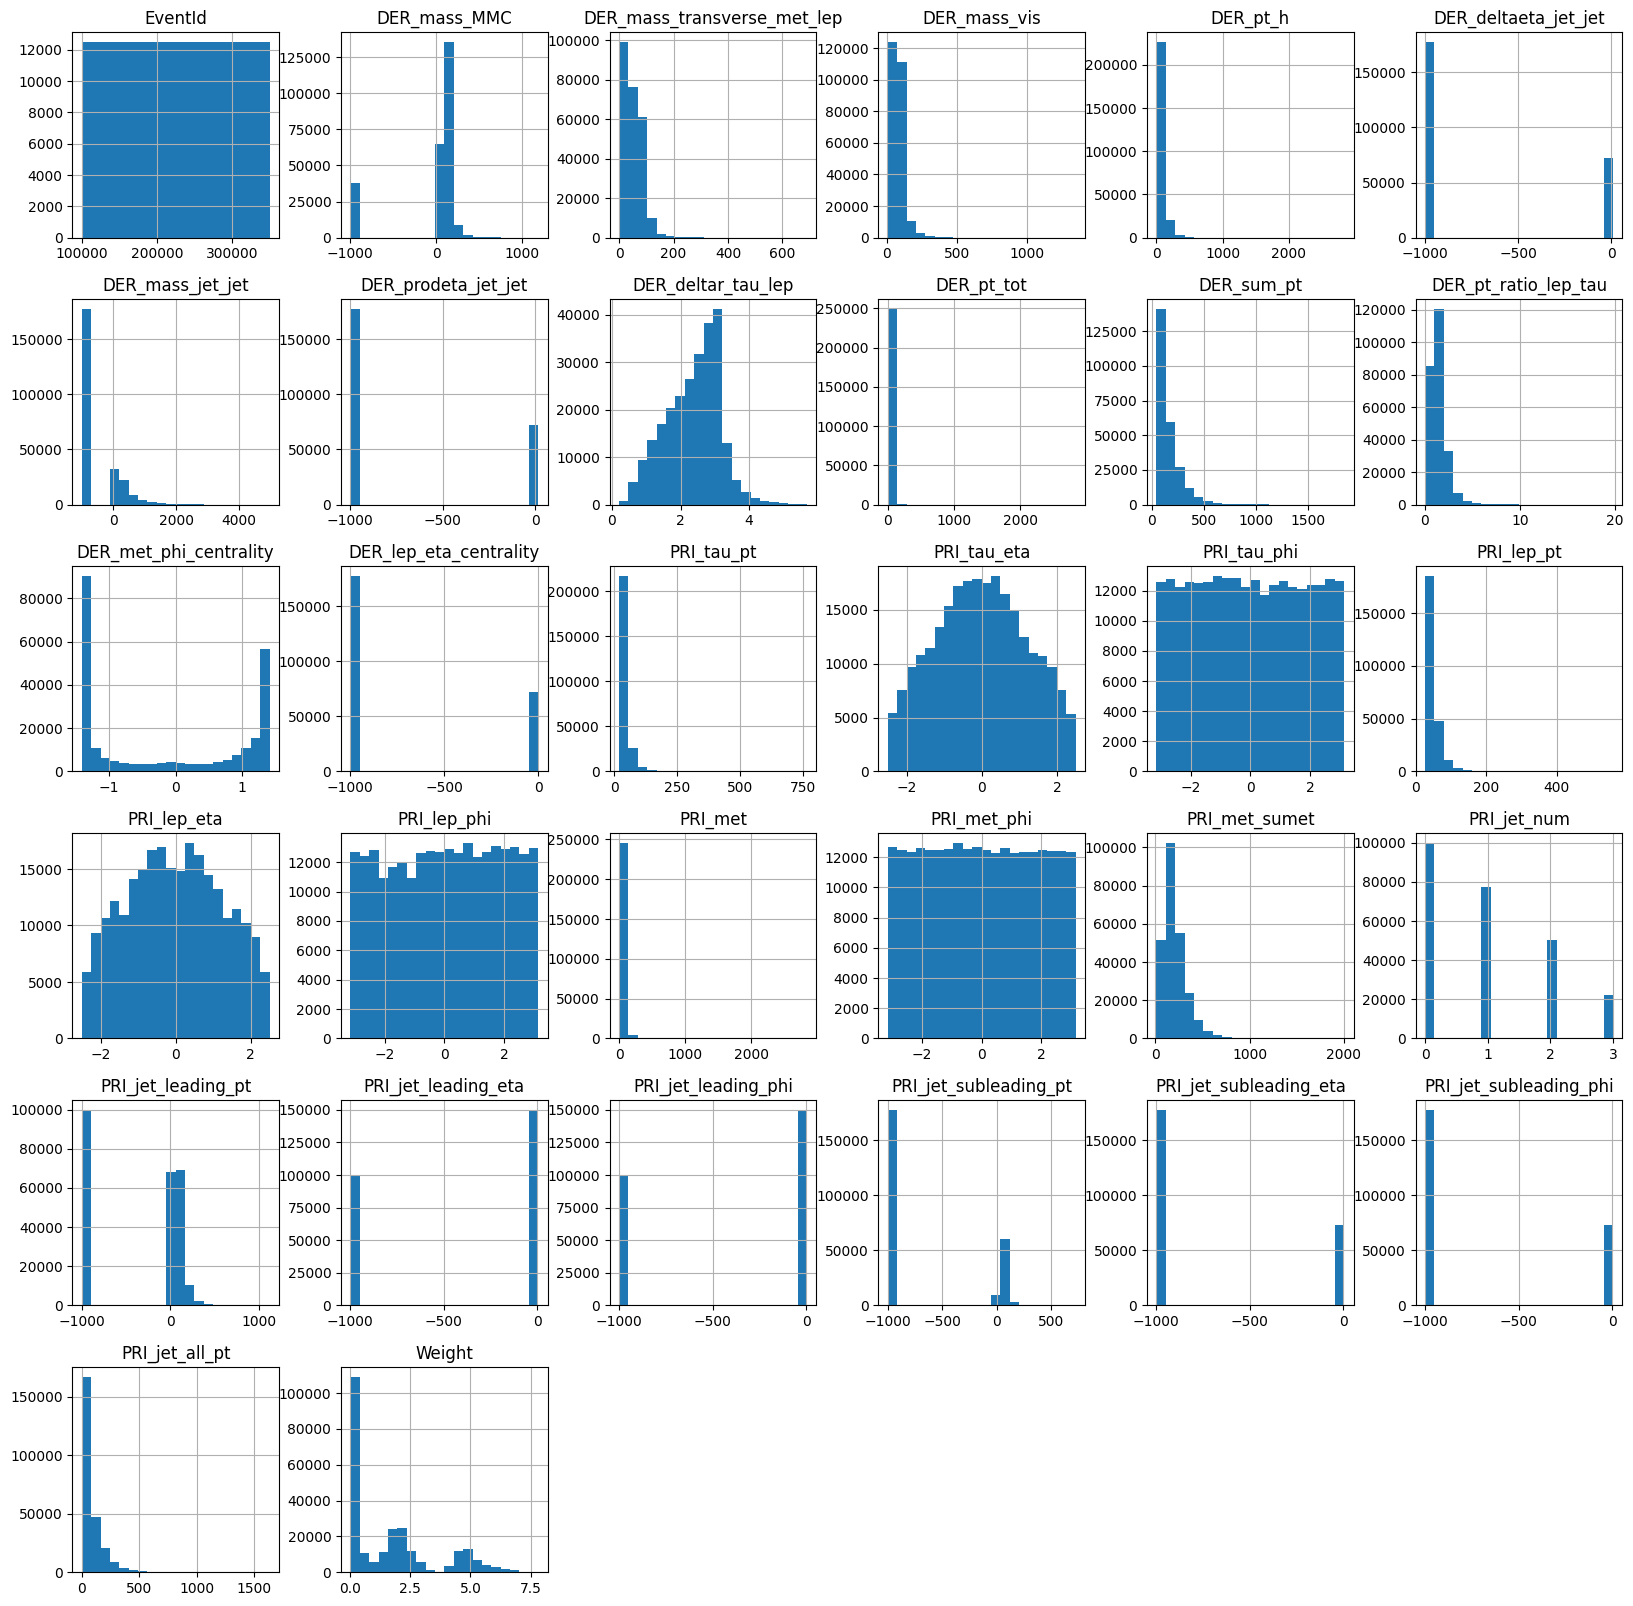

In [5]:
df.hist(layout=(6,6), bins=20, figsize=(20,20))

Text(0.5, 1.0, 'Class Distribution for signal and background events')

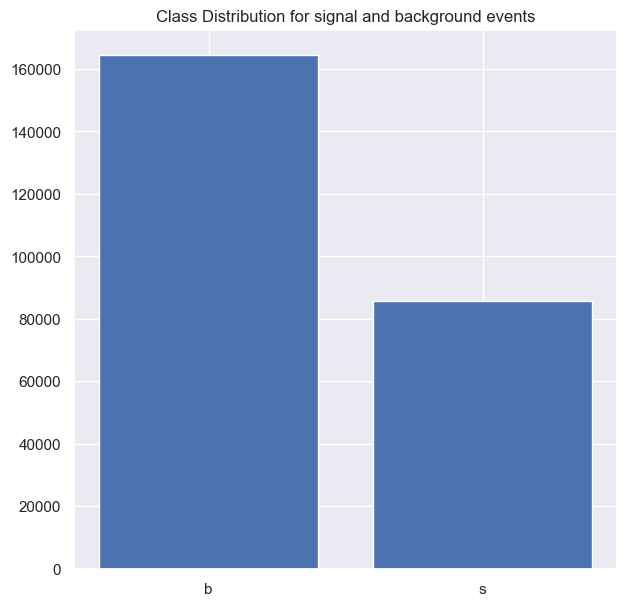

In [113]:
label_counts = df['Label'].value_counts().reset_index()
plt.bar(label_counts.Label, label_counts['count'])
plt.title("Class Distribution for signal and background events")

Text(0.5, 1.0, 'Unnormalized Class Distribution for signal and background events')

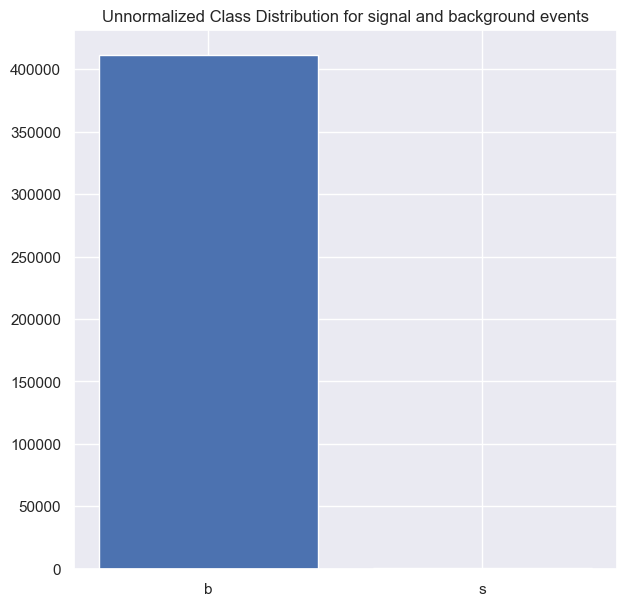

In [120]:
label_weights = df[['Weight', 'Label']].groupby('Label').sum().reset_index()
plt.bar(label_weights.Label, label_weights['Weight'])
plt.title("Unnormalized Class Distribution for signal and background events")

In [118]:
df[['Weight', 'Label']].groupby('Label').sum().reset_index()

,Label,Weight
0,b,410999.847322
1,s,691.988608


In [6]:
df = df.replace(to_replace=-999, value=np.nan)

In [7]:
df1 = df.iloc[:, 1:-2]
df1

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,197.760,1.582,1.396,0.2,32.638,1.017,0.381,51.626,2.273,-2.414,16.824,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497
1,160.937,68.768,103.235,48.146,NaN,NaN,NaN,3.473,2.078,125.157,0.879,1.414,NaN,42.014,2.039,-3.011,36.918,0.501,0.103,44.704,-1.916,164.546,1,46.226,0.725,1.158,NaN,NaN,NaN,46.226
2,NaN,162.172,125.953,35.635,NaN,NaN,NaN,3.148,9.336,197.814,3.776,1.414,NaN,32.154,-0.705,-2.093,121.409,-0.953,1.052,54.283,-2.186,260.414,1,44.251,2.053,-2.028,NaN,NaN,NaN,44.251
3,143.905,81.417,80.943,0.414,NaN,NaN,NaN,3.310,0.414,75.968,2.354,-1.285,NaN,22.647,-1.655,0.010,53.321,-0.522,-3.100,31.082,0.060,86.062,0,NaN,NaN,NaN,NaN,NaN,NaN,-0.000
4,175.864,16.915,134.805,16.405,NaN,NaN,NaN,3.891,16.405,57.983,1.056,-1.385,NaN,28.209,-2.197,-2.231,29.774,0.798,1.569,2.723,-0.871,53.131,0,NaN,NaN,NaN,NaN,NaN,NaN,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,NaN,71.989,36.548,5.042,NaN,NaN,NaN,1.392,5.042,55.892,1.258,-1.414,NaN,24.754,-0.414,-0.905,31.137,-0.950,0.380,46.520,2.859,144.665,0,NaN,NaN,NaN,NaN,NaN,NaN,0.000
249996,NaN,58.179,68.083,22.439,NaN,NaN,NaN,2.585,22.439,50.618,1.162,-1.345,NaN,23.416,-1.609,2.776,27.202,0.308,1.042,46.737,-0.867,80.408,0,NaN,NaN,NaN,NaN,NaN,NaN,-0.000
249997,105.457,60.526,75.839,39.757,NaN,NaN,NaN,2.390,22.183,120.462,1.202,0.529,NaN,35.636,-0.266,-3.132,42.834,0.381,0.851,23.419,-2.890,198.907,1,41.992,1.800,-0.166,NaN,NaN,NaN,41.992
249998,94.951,19.362,68.812,13.504,NaN,NaN,NaN,3.365,13.504,55.859,0.999,1.414,NaN,27.944,-2.211,2.792,27.915,-0.874,-0.296,12.150,0.811,112.718,0,NaN,NaN,NaN,NaN,NaN,NaN,0.000


In [8]:
X, y, weights = df1.to_numpy(), (df['Label'] == 's').astype('float').to_numpy(), df['Weight'].to_numpy()

In [9]:
y.shape

(250000,)

In [10]:
weights

array([0.0027, 2.2336, 2.3474, ..., 0.0186, 1.6816, 1.8775])

In [11]:
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(X, y, weights, test_size=0.2, random_state=35)

In [12]:
np.isnan(X_train).sum(axis=0)

array([ 30597,      0,      0,      0, 142033, 142033, 142033,      0,
            0,      0,      0,      0, 142033,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,  80044,
        80044,  80044, 142033, 142033, 142033,      0])

In [163]:
weights_train.shape

(200000,)

In [164]:
data = Data(X_train, y_train)
data.X.shape

(200000, 30)

In [165]:
len(data.nan_idx[4])

142033

In [169]:
xgb = XGBoost(obj='logistic', n_estimators=5, max_depth=5, min_samples_leaf=4, approximate=False, eps=0.05)

In [170]:
t_loss = xgb.train(data)

 20%|██        | 1/5 [00:27<01:51, 27.77s/it]

Training loss: 0.5773319790504597


 40%|████      | 2/5 [00:54<01:22, 27.43s/it]

Training loss: 0.5116673502103133


 60%|██████    | 3/5 [01:22<00:54, 27.33s/it]

Training loss: 0.4717383476089262


 80%|████████  | 4/5 [01:49<00:27, 27.20s/it]

Training loss: 0.44476832916976294


100%|██████████| 5/5 [02:16<00:00, 27.26s/it]

Training loss: 0.4263463825619128


In [168]:
t_loss

[0.5838899167482713,
 0.5219908316612897,
 0.4813582221194847,
 0.45608862792233534,
 0.4368070884127044]

In [92]:
preds = xgb.sigmoid(xgb.predict(data.X))

In [93]:
preds.shape

(200000,)

In [ ]:
np.set_printoptions(precision=4, suppress=True)
print (preds)

[0.3031 0.5105 0.0652 0.0801 0.1827 0.2458 0.4144 0.0652 0.6008 0.3094
 0.4384 0.1089 0.1475 0.3848 0.2549 0.1089 0.2686 0.3039 0.0652 0.0818
 0.0652 0.5532 0.3624 0.3002 0.1351 0.1428 0.2458 0.1866 0.1428 0.1508
 0.1827 0.5727 0.1351 0.3012 0.3045 0.4559 0.5665 0.422  0.0864 0.6607
 0.1089 0.1827 0.3614 0.1827 0.1142 0.5138 0.1428 0.1428 0.441  0.0818
 0.8973 0.4559 0.7029 0.95   0.8205 0.9025 0.7493 0.9341 0.9171 0.9368
 0.8798 0.5867 0.8027 0.9333 0.6147 0.7511 0.9331 0.9363 0.9354 0.768
 0.6147 0.3097 0.844  0.6447 0.6339 0.7546 0.3002 0.8938 0.9128 0.7693
 0.7229 0.7969 0.4894 0.8444 0.8079 0.5544 0.9153 0.8384 0.6022 0.7029
 0.3848 0.768  0.9153 0.4175 0.563  0.6908 0.8938 0.6891 0.6925 0.441 ]


In [94]:

log_loss(data.y, preds)

0.4368070884127044

In [99]:
y_preds = (preds > 0.5).astype('float')

In [101]:
(y_preds == data.y).mean()

0.81713

In [102]:
f1_score(data.y, y_preds)

0.7242237336188565

In [108]:
xgb = XGBoost(obj='logistic', n_estimators=10, max_depth=4, min_samples_leaf=4, approximate=False, eps=0.05)

In [109]:
xgb.train(data)

  0%|          | 0/10 [00:00<?, ?it/s]

 60%|██████    | 6/10 [02:32<01:40, 25.16s/it]/var/folders/mr/j7cgrptd10344f4v1yr36nv00000gn/T/ipykernel_3450/1174740298.py:18: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(gradient)/(np.sum(hessian) + lmbd)
100%|██████████| 10/10 [04:10<00:00, 25.02s/it]


In [110]:
preds = xgb.sigmoid(xgb.predict(data.X))

In [111]:
y_preds = (preds > 0.5).astype('float')
(y_preds == data.y).mean()

0.825

In [112]:
f1_score(data.y, y_preds)

0.7330648728626123

In [13]:
data = Data(X_train, y_train)
data.X.shape

(200000, 30)

In [14]:
xgb = XGBoost(obj='logistic', n_estimators=10, max_depth=5, min_samples_leaf=4, approximate=True, eps=0.05)
t_loss = xgb.train(data)

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:19<02:51, 19.04s/it]

Training loss: 0.5785982672852098


 20%|██        | 2/10 [00:37<02:28, 18.61s/it]

Training loss: 0.5151310768763916


 30%|███       | 3/10 [00:55<02:09, 18.46s/it]

Training loss: 0.47565129819112895


 40%|████      | 4/10 [01:13<01:50, 18.42s/it]

Training loss: 0.44965388444215976


 50%|█████     | 5/10 [01:32<01:31, 18.39s/it]

Training loss: 0.4323183471550409


 60%|██████    | 6/10 [01:51<01:14, 18.71s/it]

Training loss: 0.4185923405298571


/var/folders/mr/j7cgrptd10344f4v1yr36nv00000gn/T/ipykernel_12446/1009048179.py:20: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(gradient)/(np.sum(hessian) + lmbd)
 70%|███████   | 7/10 [02:10<00:55, 18.60s/it]

Training loss: 0.4102542586718683


 80%|████████  | 8/10 [02:28<00:36, 18.48s/it]

Training loss: 0.40308710614725196


 90%|█████████ | 9/10 [02:46<00:18, 18.44s/it]

Training loss: 0.39692233826166645


100%|██████████| 10/10 [03:04<00:00, 18.48s/it]

Training loss: 0.3925530310124454


In [16]:
t_loss

[0.5785982672852098,
 0.5151310768763916,
 0.47565129819112895,
 0.44965388444215976,
 0.4323183471550409,
 0.4185923405298571,
 0.4102542586718683,
 0.40308710614725196,
 0.39692233826166645,
 0.3925530310124454]

In [57]:
xgb = XGBoost(obj='logistic', n_estimators=10, max_depth=4, min_samples_leaf=4, approximate=True, eps=0.05)
xgb.train(data)

 60%|██████    | 6/10 [01:36<01:03, 15.78s/it]/var/folders/mr/j7cgrptd10344f4v1yr36nv00000gn/T/ipykernel_9839/299677537.py:18: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(gradient)/(np.sum(hessian) + lmbd)
100%|██████████| 10/10 [02:40<00:00, 16.01s/it]


In [103]:
preds = xgb.sigmoid(xgb.predict(data.X))
y_preds = (preds > 0.5).astype('float')
(y_preds == data.y).mean()

0.82033

In [58]:
preds = xgb.sigmoid(xgb.predict(data.X))
y_preds = (preds > 0.5).astype('float')
(y_preds == data.y).mean()

0.819895

In [104]:
f1_score(data.y, y_preds)

0.7243056621144699

In [105]:
data = Data(X_train, y_train)
print (data.X.shape)
xgb = XGBoost(obj='logistic', n_estimators=20, lmbd=1., max_depth=3, min_samples_leaf=4, approximate=True, eps=0.05)
xgb.train(data)

(200000, 30)


100%|██████████| 20/20 [03:19<00:00,  9.99s/it]


In [106]:
preds = xgb.sigmoid(xgb.predict(data.X))
y_preds = (preds > 0.5).astype('float')
print ('acc:', (y_preds == data.y).mean())
print ('f1 score:', f1_score(data.y, y_preds))

acc: 0.817795
f1 score: 0.7165117274106343


In [12]:
data = Data(X_train, y_train)
print (data.X.shape)
xgb = XGBoost(obj='logistic', n_estimators=20, lmbd=1., max_depth=3, min_samples_leaf=4, approximate=True, eps=0.05, num_features=20)
t_loss = xgb.train(data)

(200000, 30)


 20%|██        | 1/5 [00:12<00:51, 12.76s/it]

Training loss: 0.581863909005619


 40%|████      | 2/5 [00:25<00:37, 12.52s/it]

Training loss: 0.5158962881889358


 60%|██████    | 3/5 [00:36<00:24, 12.18s/it]

Training loss: 0.47673257782900996


 80%|████████  | 4/5 [00:48<00:12, 12.14s/it]

Training loss: 0.4490744664512957


100%|██████████| 5/5 [01:00<00:00, 12.18s/it]

Training loss: 0.4301081713301326


In [175]:
t_loss

[0.5816225040322399,
 0.5165615797200368,
 0.47509678357365714,
 0.4486191790783022,
 0.4307675085827053,
 0.4189903172062843,
 0.4103086817381997,
 0.40285504691025364,
 0.398161660746328,
 0.3939713898246064,
 0.3914224098650572,
 0.38830581976829404,
 0.38621281474635305,
 0.3847937737988558,
 0.3828025964760796,
 0.38179162287930984,
 0.3808894561113599,
 0.37848734065583334,
 0.3769329623717133,
 0.37620786840570514]

Text(0, 0.5, 'Loss')

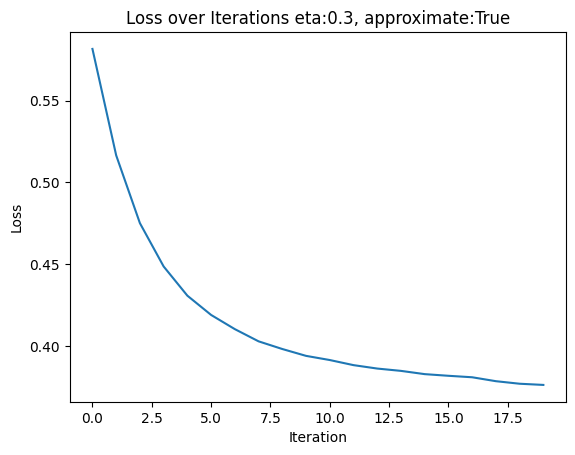

In [176]:
plt.plot(np.arange(len(t_loss)), t_loss)
plt.title("Loss over Iterations eta:{}, approximate:{}".format(xgb.eta, xgb.approximate))
plt.xlabel("Iteration")
plt.ylabel("Loss")

In [108]:
preds = xgb.sigmoid(xgb.predict(data.X))
y_preds = (preds > 0.5).astype('float')
print ('acc:', (y_preds == data.y).mean())
print ('f1 score:', f1_score(data.y, y_preds))

acc: 0.82137
f1 score: 0.7250450228577585


In [109]:
preds = xgb.sigmoid(xgb.predict(X_test))
y_preds = (preds > 0.5).astype('float')
print ('acc:', (y_preds == y_test).mean())
print ('f1 score:', f1_score(y_test, y_preds))

acc: 0.81804
f1 score: 0.7203712810425374


In [110]:
data = Data(X_train, y_train)
print (data.X.shape)
xgb = XGBoost(obj='logistic', n_estimators=40, lmbd=2., max_depth=5, min_samples_leaf=4, approximate=True, eps=0.01, num_features=20)
xgb.train(data)

(200000, 30)


100%|██████████| 40/40 [07:49<00:00, 11.74s/it]


In [115]:
preds = xgb.sigmoid(xgb.predict(data.X))
y_preds = (preds > 0.5).astype('float')
print ('acc:', (y_preds == data.y).mean())
print ('f1 score:', f1_score(data.y, y_preds))
print ('auc:', roc_auc_score(data.y, y_preds))

acc: 0.840165
f1 score: 0.7569733230954028
auc: 0.8132054910953497


In [114]:
preds = xgb.sigmoid(xgb.predict(X_test))
y_preds = (preds > 0.5).astype('float')
print ('acc:', (y_preds == y_test).mean())
print ('f1 score:', f1_score(y_test, y_preds))
print ('auc:', roc_auc_score(y_test, y_preds))

acc: 0.83446
f1 score: 0.748274079255497
auc: 0.8056030326854245


In [14]:
data = Data(X_train, y_train)
print (data.X.shape)
xgb = XGBoost(obj='logistic', eta=0.1, n_estimators=5, lmbd=2., max_depth=5, min_samples_leaf=4, approximate=True, eps=0.005, num_features=20)
xgb.train(data)

(200000, 30)


 20%|██        | 1/5 [00:12<00:49, 12.32s/it]

Training loss: 0.6513345419622956


 40%|████      | 2/5 [00:25<00:37, 12.63s/it]

Training loss: 0.6157186763120981


 60%|██████    | 3/5 [00:37<00:25, 12.67s/it]

Training loss: 0.5855136983094057


 80%|████████  | 4/5 [00:50<00:12, 12.54s/it]

Training loss: 0.5603782785686882


100%|██████████| 5/5 [01:03<00:00, 12.64s/it]

Training loss: 0.5391078956915926


[0.6513345419622956,
 0.6157186763120981,
 0.5855136983094057,
 0.5603782785686882,
 0.5391078956915926]

In [117]:
preds = xgb.sigmoid(xgb.predict(data.X))
y_preds = (preds > 0.5).astype('float')
print ('acc:', (y_preds == data.y).mean())
print ('f1 score:', f1_score(data.y, y_preds))
print ('auc:', roc_auc_score(data.y, y_preds))

acc: 0.84612
f1 score: 0.765584059472305
auc: 0.8193841836291339


In [118]:
preds = xgb.sigmoid(xgb.predict(X_test))
y_preds = (preds > 0.5).astype('float')
print ('acc:', (y_preds == y_test).mean())
print ('f1 score:', f1_score(y_test, y_preds))
print ('auc:', roc_auc_score(y_test, y_preds))

acc: 0.83676
f1 score: 0.7512798634812285
auc: 0.8077017168132715


In [130]:
train_weight, test_weight = train_test_split(df['Weight'].to_numpy(), test_size=0.2, random_state=35)

In [131]:
train_weight

array([0.30716952, 2.69411304, 1.45484847, ..., 0.01863612, 5.46338771,
       1.37339095])

In [137]:
s = test_weight[(y_preds==1) & (y_test==1)].sum()
b = test_weight[(y_preds==1) & (y_test==0)].sum()
print (s,b)

93.62367937328212 5399.477182500526


In [22]:
def AMS(s, b):
    br = 10.0
    radicand = 2 *( (s+b+br) * np.log(1.0 + s/(b+br)) -s)
    if radicand < 0:
        print ('radicand is negative. Exiting')
        raise ValueError
    else:
        return np.sqrt(radicand)

In [139]:
AMS(s, b)

1.269294723829901

In [128]:
train_weight, test_weight = train_test_split(df['Weight'], test_size=0.2, random_state=35)

In [144]:
test_weight[(y_test==0)].mean()

2.498528325953063

In [145]:
test_weight[(y_test==1)].mean()

0.008073252456170247

In [13]:
weights_train = np.ones(y_train.shape)
weights_train[y_train == 0] = 4

In [14]:
data = Data(X_train, y_train)
print (data.X.shape)
xgb = XGBoost(obj='logistic', eta=0.1, n_estimators=100, lmbd=0.5, 
              max_depth=6, min_samples_leaf=2, approximate=True, 
              eps=0.005, num_features=20, case_weights=weights_train)
t_loss = xgb.train(data)

(200000, 30)


  1%|          | 1/100 [00:17<28:49, 17.47s/it]

Training loss: 0.6496881958865054


  2%|▏         | 2/100 [00:33<26:51, 16.44s/it]

Training loss: 0.6156360052994807


  3%|▎         | 3/100 [00:48<26:04, 16.13s/it]

Training loss: 0.58790941724214


  4%|▍         | 4/100 [01:04<25:09, 15.73s/it]

Training loss: 0.5655023366892741


  5%|▌         | 5/100 [01:19<24:37, 15.55s/it]

Training loss: 0.5471221917732589


  6%|▌         | 6/100 [01:34<23:58, 15.31s/it]

Training loss: 0.5326033145757698


  7%|▋         | 7/100 [01:49<23:57, 15.46s/it]

Training loss: 0.5202771423920729


  8%|▊         | 8/100 [02:05<23:42, 15.46s/it]

Training loss: 0.5097645098385901


  9%|▉         | 9/100 [02:21<23:34, 15.55s/it]

Training loss: 0.5010595858324792


 10%|█         | 10/100 [02:37<23:29, 15.66s/it]

Training loss: 0.4939575916066056


 11%|█         | 11/100 [02:53<23:23, 15.77s/it]

Training loss: 0.48831909278305524


 12%|█▏        | 12/100 [03:09<23:22, 15.93s/it]

Training loss: 0.48332958665494086


 13%|█▎        | 13/100 [03:25<23:22, 16.12s/it]

Training loss: 0.47971556463010273


 14%|█▍        | 14/100 [03:41<22:59, 16.04s/it]

Training loss: 0.47663723933271884


 15%|█▌        | 15/100 [03:58<22:51, 16.13s/it]

Training loss: 0.4741501268659119


 16%|█▌        | 16/100 [04:15<22:58, 16.41s/it]

Training loss: 0.47237730435988984


 17%|█▋        | 17/100 [04:32<23:16, 16.83s/it]

Training loss: 0.4711771503808686


 18%|█▊        | 18/100 [04:50<23:21, 17.09s/it]

Training loss: 0.4702374729157678


 19%|█▉        | 19/100 [05:07<22:51, 16.93s/it]

Training loss: 0.4695071675028865


 20%|██        | 20/100 [05:22<22:00, 16.50s/it]

Training loss: 0.4689423980483663


 21%|██        | 21/100 [05:38<21:14, 16.14s/it]

Training loss: 0.46816477048833627


 22%|██▏       | 22/100 [05:53<20:38, 15.88s/it]

Training loss: 0.4679232774666008


 23%|██▎       | 23/100 [06:08<20:14, 15.77s/it]

Training loss: 0.46798017087543486


 24%|██▍       | 24/100 [06:24<19:47, 15.62s/it]

Training loss: 0.46772233556472814


 25%|██▌       | 25/100 [06:39<19:27, 15.57s/it]

Training loss: 0.468088598156225


 26%|██▌       | 26/100 [06:55<19:11, 15.56s/it]

Training loss: 0.468185561088769


 27%|██▋       | 27/100 [07:10<18:51, 15.51s/it]

Training loss: 0.4679119456743726


 28%|██▊       | 28/100 [07:25<18:33, 15.47s/it]

Training loss: 0.4681086396135402


 29%|██▉       | 29/100 [07:41<18:19, 15.49s/it]

Training loss: 0.46797584380192575


 30%|███       | 30/100 [07:56<18:01, 15.45s/it]

Training loss: 0.4679769359731021


 31%|███       | 31/100 [08:12<17:45, 15.44s/it]

Training loss: 0.4679254444261526


 32%|███▏      | 32/100 [08:28<17:38, 15.57s/it]

Training loss: 0.4678075042798111


 33%|███▎      | 33/100 [08:43<17:13, 15.42s/it]

Training loss: 0.4676684127742323


 34%|███▍      | 34/100 [08:58<16:55, 15.39s/it]

Training loss: 0.4675414751604143


 35%|███▌      | 35/100 [09:13<16:44, 15.45s/it]

Training loss: 0.4678797167576251


 36%|███▌      | 36/100 [09:29<16:30, 15.48s/it]

Training loss: 0.46740911701805277


 37%|███▋      | 37/100 [09:45<16:15, 15.48s/it]

Training loss: 0.4672561180213162


 38%|███▊      | 38/100 [09:59<15:44, 15.23s/it]

Training loss: 0.4671317729730109


 39%|███▉      | 39/100 [10:13<15:02, 14.79s/it]

Training loss: 0.4674215206282024


 40%|████      | 40/100 [10:27<14:38, 14.64s/it]

Training loss: 0.4672346740893214


 41%|████      | 41/100 [10:42<14:25, 14.68s/it]

Training loss: 0.46696299803935865


 42%|████▏     | 42/100 [10:57<14:10, 14.67s/it]

Training loss: 0.4664391934717855


 43%|████▎     | 43/100 [11:11<13:47, 14.51s/it]

Training loss: 0.4659362596216919


 44%|████▍     | 44/100 [11:25<13:34, 14.54s/it]

Training loss: 0.465405549583727


 45%|████▌     | 45/100 [11:40<13:14, 14.44s/it]

Training loss: 0.4647965184052677


 46%|████▌     | 46/100 [11:53<12:41, 14.10s/it]

Training loss: 0.4647467420079292


 47%|████▋     | 47/100 [12:06<12:16, 13.89s/it]

Training loss: 0.4642266938981924


 48%|████▊     | 48/100 [12:20<12:04, 13.93s/it]

Training loss: 0.4636029448025368


 49%|████▉     | 49/100 [12:35<11:55, 14.04s/it]

Training loss: 0.4632999032012584


 50%|█████     | 50/100 [12:49<11:51, 14.24s/it]

Training loss: 0.4626059477180065


 51%|█████     | 51/100 [13:03<11:24, 13.96s/it]

Training loss: 0.462228373752357


 52%|█████▏    | 52/100 [13:16<11:05, 13.86s/it]

Training loss: 0.4618636733895215


 53%|█████▎    | 53/100 [13:30<10:56, 13.97s/it]

Training loss: 0.46150063038225364


 54%|█████▍    | 54/100 [13:44<10:31, 13.73s/it]

Training loss: 0.46122153350740047


 55%|█████▌    | 55/100 [13:57<10:07, 13.49s/it]

Training loss: 0.4610351918578597


 56%|█████▌    | 56/100 [14:10<09:54, 13.52s/it]

Training loss: 0.46062265956723836


 57%|█████▋    | 57/100 [14:24<09:44, 13.60s/it]

Training loss: 0.46035626524352635


 58%|█████▊    | 58/100 [14:37<09:29, 13.56s/it]

Training loss: 0.45998023767355845


 59%|█████▉    | 59/100 [14:51<09:18, 13.63s/it]

Training loss: 0.4593557574278043


 60%|██████    | 60/100 [15:04<08:59, 13.50s/it]

Training loss: 0.45922813045460337


 61%|██████    | 61/100 [15:18<08:42, 13.40s/it]

Training loss: 0.4589127107953403


 62%|██████▏   | 62/100 [15:31<08:25, 13.29s/it]

Training loss: 0.45854851792172563


 63%|██████▎   | 63/100 [15:45<08:21, 13.55s/it]

Training loss: 0.45805974712803155


 64%|██████▍   | 64/100 [15:59<08:11, 13.66s/it]

Training loss: 0.4574149978425318


 65%|██████▌   | 65/100 [16:13<07:59, 13.71s/it]

Training loss: 0.4571164984792441


 66%|██████▌   | 66/100 [16:26<07:40, 13.56s/it]

Training loss: 0.45666079439862406


 67%|██████▋   | 67/100 [16:39<07:26, 13.52s/it]

Training loss: 0.4562960905022488


 68%|██████▊   | 68/100 [16:52<07:08, 13.39s/it]

Training loss: 0.4560237522776559


 69%|██████▉   | 69/100 [17:05<06:52, 13.30s/it]

Training loss: 0.455751406826785


 70%|███████   | 70/100 [17:20<06:47, 13.57s/it]

Training loss: 0.45529910349467106


 71%|███████   | 71/100 [17:33<06:35, 13.65s/it]

Training loss: 0.4550037952435373


 72%|███████▏  | 72/100 [17:48<06:29, 13.91s/it]

Training loss: 0.4546247500427131


 73%|███████▎  | 73/100 [18:02<06:17, 13.99s/it]

Training loss: 0.4539947976829524


 74%|███████▍  | 74/100 [18:15<05:52, 13.57s/it]

Training loss: 0.4537273212870864


 75%|███████▌  | 75/100 [18:29<05:45, 13.84s/it]

Training loss: 0.45319843640486185


 76%|███████▌  | 76/100 [18:44<05:39, 14.13s/it]

Training loss: 0.4526536541623921


 77%|███████▋  | 77/100 [18:59<05:29, 14.33s/it]

Training loss: 0.45228362116315535


 78%|███████▊  | 78/100 [19:12<05:06, 13.95s/it]

Training loss: 0.4520847882021021


 79%|███████▉  | 79/100 [19:26<04:57, 14.16s/it]

Training loss: 0.4514338280480783


 80%|████████  | 80/100 [19:41<04:44, 14.22s/it]

Training loss: 0.45099686196245653


 81%|████████  | 81/100 [19:55<04:31, 14.28s/it]

Training loss: 0.4506695463123133


 82%|████████▏ | 82/100 [20:09<04:16, 14.26s/it]

Training loss: 0.45015154964110515


 83%|████████▎ | 83/100 [20:22<03:56, 13.89s/it]

Training loss: 0.4500079467623965


 84%|████████▍ | 84/100 [20:35<03:38, 13.64s/it]

Training loss: 0.44982034064056403


 85%|████████▌ | 85/100 [20:50<03:28, 13.88s/it]

Training loss: 0.4494819862502224


 86%|████████▌ | 86/100 [21:05<03:17, 14.09s/it]

Training loss: 0.4490929166933871


 87%|████████▋ | 87/100 [21:19<03:03, 14.14s/it]

Training loss: 0.4486858610364214


 88%|████████▊ | 88/100 [21:33<02:48, 14.02s/it]

Training loss: 0.44841162063604345


 89%|████████▉ | 89/100 [21:47<02:34, 14.09s/it]

Training loss: 0.44803846688763893


 90%|█████████ | 90/100 [22:01<02:22, 14.24s/it]

Training loss: 0.4477543523920775


 91%|█████████ | 91/100 [22:16<02:08, 14.31s/it]

Training loss: 0.44735222377886763


 92%|█████████▏| 92/100 [22:30<01:54, 14.34s/it]

Training loss: 0.44688822463930533


 93%|█████████▎| 93/100 [22:45<01:40, 14.33s/it]

Training loss: 0.4466423951813763


 94%|█████████▍| 94/100 [22:59<01:26, 14.36s/it]

Training loss: 0.4463466321974694


 95%|█████████▌| 95/100 [23:13<01:12, 14.40s/it]

Training loss: 0.4460795789554048


 96%|█████████▌| 96/100 [23:28<00:57, 14.47s/it]

Training loss: 0.445701665313977


 97%|█████████▋| 97/100 [23:43<00:43, 14.50s/it]

Training loss: 0.4452887155855122


 98%|█████████▊| 98/100 [23:57<00:29, 14.50s/it]

Training loss: 0.44500372845747677


 99%|█████████▉| 99/100 [24:12<00:14, 14.59s/it]

Training loss: 0.44456683991402335


100%|██████████| 100/100 [24:26<00:00, 14.67s/it]

Training loss: 0.4441568497367779


[0.6496881958865054,
 0.6156360052994807,
 0.58790941724214,
 0.5655023366892741,
 0.5471221917732589,
 0.5326033145757698,
 0.5202771423920729,
 0.5097645098385901,
 0.5010595858324792,
 0.4939575916066056,
 0.48831909278305524,
 0.48332958665494086,
 0.47971556463010273,
 0.47663723933271884,
 0.4741501268659119,
 0.47237730435988984,
 0.4711771503808686,
 0.4702374729157678,
 0.4695071675028865,
 0.4689423980483663,
 0.46816477048833627,
 0.4679232774666008,
 0.46798017087543486,
 0.46772233556472814,
 0.468088598156225,
 0.468185561088769,
 0.4679119456743726,
 0.4681086396135402,
 0.46797584380192575,
 0.4679769359731021,
 0.4679254444261526,
 0.4678075042798111,
 0.4676684127742323,
 0.4675414751604143,
 0.4678797167576251,
 0.46740911701805277,
 0.4672561180213162,
 0.4671317729730109,
 0.4674215206282024,
 0.4672346740893214,
 0.46696299803935865,
 0.4664391934717855,
 0.4659362596216919,
 0.465405549583727,
 0.4647965184052677,
 0.4647467420079292,
 0.4642266938981924,
 0.4636

In [15]:
t_loss = [0.6496881958865054,
 0.6156360052994807,
 0.58790941724214,
 0.5655023366892741,
 0.5471221917732589,
 0.5326033145757698,
 0.5202771423920729,
 0.5097645098385901,
 0.5010595858324792,
 0.4939575916066056,
 0.48831909278305524,
 0.48332958665494086,
 0.47971556463010273,
 0.47663723933271884,
 0.4741501268659119,
 0.47237730435988984,
 0.4711771503808686,
 0.4702374729157678,
 0.4695071675028865,
 0.4689423980483663,
 0.46816477048833627,
 0.4679232774666008,
 0.46798017087543486,
 0.46772233556472814,
 0.468088598156225,
 0.468185561088769,
 0.4679119456743726,
 0.4681086396135402,
 0.46797584380192575,
 0.4679769359731021,
 0.4679254444261526,
 0.4678075042798111,
 0.4676684127742323,
 0.4675414751604143,
 0.4678797167576251,
 0.46740911701805277,
 0.4672561180213162,
 0.4671317729730109,
 0.4674215206282024,
 0.4672346740893214,
 0.46696299803935865,
 0.4664391934717855,
 0.4659362596216919,
 0.465405549583727,
 0.4647965184052677,
 0.4647467420079292,
 0.4642266938981924,
 0.4636029448025368,
 0.4632999032012584,
 0.4626059477180065,
 0.462228373752357,
 0.4618636733895215,
 0.46150063038225364,
 0.46122153350740047,
 0.4610351918578597,
 0.46062265956723836,
 0.46035626524352635,
 0.45998023767355845,
 0.4593557574278043,
 0.45922813045460337,
 0.4589127107953403,
 0.45854851792172563,
 0.45805974712803155,
 0.4574149978425318,
 0.4571164984792441,
 0.45666079439862406,
 0.4562960905022488,
 0.4560237522776559,
 0.455751406826785,
 0.45529910349467106,
 0.4550037952435373,
 0.4546247500427131,
 0.4539947976829524,
 0.4537273212870864,
 0.45319843640486185,
 0.4526536541623921,
 0.45228362116315535,
 0.4520847882021021,
 0.4514338280480783,
 0.45099686196245653,
 0.4506695463123133,
 0.45015154964110515,
 0.4500079467623965,
 0.44982034064056403,
 0.4494819862502224,
 0.4490929166933871,
 0.4486858610364214,
 0.44841162063604345,
 0.44803846688763893,
 0.4477543523920775,
 0.44735222377886763,
 0.44688822463930533,
 0.4466423951813763,
 0.4463466321974694,
 0.4460795789554048,
 0.445701665313977,
 0.4452887155855122,
 0.44500372845747677,
 0.44456683991402335,
 0.4441568497367779]

Text(0, 0.5, 'Loss')

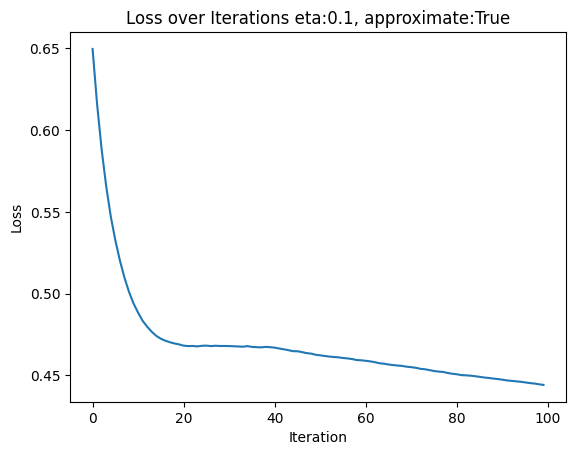

In [16]:
plt.plot(np.arange(len(t_loss)), t_loss)
plt.title("Loss over Iterations eta:{}, approximate:{}".format(xgb.eta, xgb.approximate))
plt.xlabel("Iteration")
plt.ylabel("Loss")

In [63]:
preds = xgb.sigmoid(xgb.predict(data.X))
y_preds = (preds > 0.5).astype('float')
print ('acc:', (y_preds == data.y).mean())
print ('f1 score:', f1_score(data.y, y_preds))
print ('auc:', roc_auc_score(data.y, preds))

acc: 0.80068
f1 score: 0.6092224444183038
auc: 0.9150165875812192


In [ ]:
def print_best_asm(y_true, y_pred, case_weights):
    thresholds = np.arange(30,95)
    ams_scores = []
    f1_scores = []

    for threshold in thresholds:
        limit = np.percentile(y_pred, threshold)
        y_thesholded = y_pred > limit
        s = case_weights[(y_thesholded==1) & (y_true==1)].sum()
        b = case_weights[(y_thesholded==1) & (y_true==0)].sum()
        print (s,b, limit)
        score = AMS(s, b)
        ams_scores.append(score)
        f1_scores.append(f1_score(y_true, y_thesholded))

    print ("Best ams score of ",max(ams_scores), " at threshold of ",thresholds[np.argmax(ams_scores)])
    print ("Best f1 score of ",max(f1_scores), " at threshold of ",thresholds[np.argmax(f1_scores)])

In [64]:
# Train Thresholds
# train_preds = xgb.sigmoid(xgb.predict(X_train))
print_best_asm(y_train, preds, weights_train*550000/len(weights_train))

184659.75 801361.0 0.020404118348079783
184307.75 780769.0 0.021582877565329273
183966.75 760133.0 0.02279328088788331
183620.25 739519.0 0.024072606649038753
183207.75 719169.0 0.025465573619813792
182776.0 698896.0 0.026907653327733625
182330.5 678678.0 0.028503612704349018
181857.5 658570.0 0.03012757352837521
181376.25 638495.0 0.031836758409341005
180870.25 618519.0 0.03360967031554398
180240.5 599038.0 0.035452433588545745
179577.75 579689.0 0.03744658751678294
178884.75 560461.0 0.03961341851321811
178252.25 540991.0 0.04190715674390399
177520.75 521917.0 0.044339784129462406
176709.5 503162.0 0.04690087574182406
175903.75 484385.0 0.04959966499213654
175070.5 465718.0 0.05235527516498296
174171.25 447315.0 0.05538703319542886
173140.0 429440.0 0.058486324320633484
172020.75 411917.0 0.06185762476808322
170876.75 394493.0 0.06547088545509595
169677.75 377289.0 0.06943764465570335
168462.25 360151.0 0.07371517702817716
167095.5 343618.0 0.07807190542822945
165728.75 327085.0 0.08

In [65]:
np.percentile(preds, 85)

0.5454008399594703

In [18]:
preds = xgb.sigmoid(xgb.predict(X_test))
y_preds = (preds > 0.5).astype('float')
print ('acc:', (y_preds == y_test).mean())
print ('f1 score:', f1_score(y_test, y_preds))
print ('auc:', roc_auc_score(y_test, preds))

acc: 0.79578
f1 score: 0.6011795492715698
auc: 0.9074842599221125


In [24]:
# Test Thresholds
print_best_asm(y_test, preds, weights_test*550000/len(weights_test))

1516.3507788498525 413312.7882191007 0.020531899197499485
1513.4326214251691 399985.17633368 0.021773876003763626
1508.6755006549884 387718.2760882719 0.0230358564020147
1505.3677748215714 375055.8277276418 0.024468727940924317
1501.5325888679326 363132.1925184098 0.025888604973913442
1497.8264326240896 351349.8494369321 0.027400500699977258
1492.9156335672126 339392.15278365265 0.028941836106797937
1488.6332120680695 327963.3602005985 0.030665148603053916
1483.5560780529265 316056.98820840864 0.03236216168964847
1478.9842256790569 304296.35621963063 0.03423656099264337
1474.1742889713348 293332.7258111177 0.03611639988212286
1469.2922994577125 282059.8856897715 0.038230553070892105
1463.6089663637842 270916.84420441766 0.04035337172540652
1457.0307231709398 260100.4518856598 0.04255850555443145
1448.927915734026 249443.98126116724 0.04490863876478772
1439.0936609487026 240507.7397795716 0.04731289751290113
1430.123326649169 230667.87782716117 0.04989941118311425
1419.529521252015 2212

In [26]:
limit = np.percentile(preds, 85)
print (limit)
preds = xgb.sigmoid(xgb.predict(X_test))
y_preds = (preds > limit).astype('float')
print ('acc:', (y_preds == y_test).mean())
print ('f1 score:', f1_score(y_test, y_preds))
print ('auc:', roc_auc_score(y_test, preds))
factor = 550000/len(preds)
s = weights_test[(y_preds==1) & (y_test==1)].sum() * factor
b = weights_test[(y_preds==1) & (y_test==0)].sum() * factor
print (s,b)
print ('AMS:', AMS(s, b))

0.5434980892342655
acc: 0.78476
f1 score: 0.5655578879379946
auc: 0.9074842599221125
490.8120551437762 7461.185591695613
AMS: 5.617798195868161


In [28]:
s = weights_test[(y_preds==1) & (y_test==1)].sum()
b = weights_test[(y_preds==1) & (y_test==0)].sum()
print (s,b)

44.61927774034329 678.2895992450557


In [29]:
weights_train[y_train==0].sum()/weights_train[y_train==1].sum()

7.696761459170992

In [30]:
AMS(s, b)

1.6828399386004793

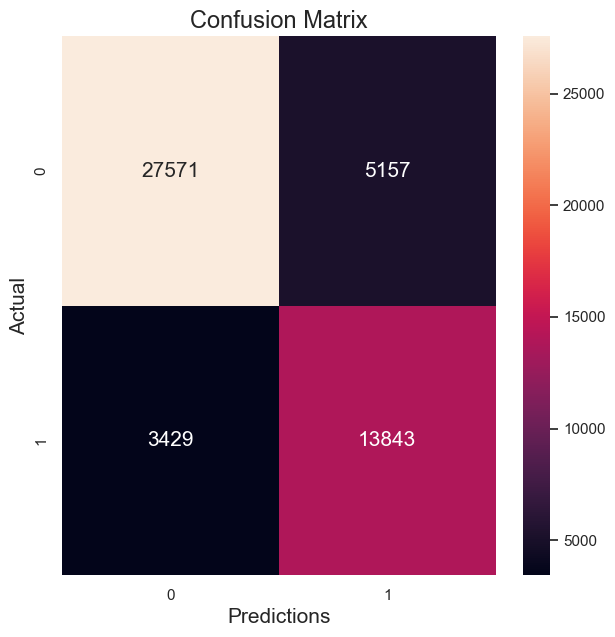

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
limit = np.percentile(preds, 62)
y_preds = (preds > limit).astype('float')
# plt.figure(figsize=(20,20))
sns.set(rc={'figure.figsize':(7,7)})
sns.heatmap(confusion_matrix(y_test, y_preds), annot=True, annot_kws={"size": 15}, fmt='g')
plt.ylabel('Actual',fontsize=15)
plt.xlabel('Predictions',fontsize=15)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [232]:
weights_test[y_test==0].sum()/weights_test[y_test==1].sum()

586.4251413567

In [32]:
df_test = pd.read_csv("higgs-boson/test.csv")
df_test

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,350000,-999.000,79.589,23.916,3.036,-999.000,-999.000,-999.000,0.903,3.036,56.018,1.536,-1.404,-999.000,22.088,-0.540,-0.609,33.930,-0.504,-1.511,48.509,2.022,98.556,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000
1,350001,106.398,67.490,87.949,49.994,-999.000,-999.000,-999.000,2.048,2.679,132.865,1.777,-1.204,-999.000,30.716,-1.784,3.054,54.574,-0.169,1.795,21.093,-1.138,176.251,1,47.575,-0.553,-0.849,-999.000,-999.000,-999.000,47.575
2,350002,117.794,56.226,96.358,4.137,-999.000,-999.000,-999.000,2.755,4.137,97.600,1.096,-1.408,-999.000,46.564,-0.298,3.079,51.036,-0.548,0.336,19.461,-1.868,111.505,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
3,350003,135.861,30.604,97.288,9.104,-999.000,-999.000,-999.000,2.811,9.104,94.112,0.819,-1.382,-999.000,51.741,0.388,-1.408,42.371,-0.295,2.148,25.131,1.172,164.707,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
4,350004,74.159,82.772,58.731,89.646,1.347,536.663,-0.339,1.028,77.213,721.552,1.713,-0.913,0.004,45.087,-1.548,1.877,77.252,-1.913,2.838,22.200,-0.231,869.614,3,254.085,-1.013,-0.334,185.857,0.335,2.587,599.213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549995,899995,309.530,28.185,170.795,99.349,-999.000,-999.000,-999.000,3.061,2.367,212.640,0.708,1.346,-999.000,67.429,0.657,-2.560,47.761,-1.372,1.431,61.754,1.956,177.103,1,97.451,-1.759,-0.733,-999.000,-999.000,-999.000,97.451
549996,899996,105.653,5.096,77.256,33.040,-999.000,-999.000,-999.000,2.693,33.040,62.279,0.948,0.551,-999.000,31.964,0.162,-2.624,30.315,-1.404,-0.432,12.670,-0.172,130.730,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000
549997,899997,-999.000,69.470,51.766,1.189,-999.000,-999.000,-999.000,1.615,1.189,72.350,0.752,-1.398,-999.000,41.290,0.559,-2.156,31.060,0.578,2.512,49.505,0.336,71.646,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000
549998,899998,107.254,13.500,79.833,50.801,-999.000,-999.000,-999.000,2.026,7.993,135.762,1.087,-0.288,-999.000,44.403,-0.504,1.710,48.260,-0.096,-0.274,7.741,-0.988,243.371,1,43.099,-0.352,-2.594,-999.000,-999.000,-999.000,43.099


In [33]:
df_test.describe()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
count,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000
mean,624999.500000,-48.950144,49.261093,81.123904,57.824801,-707.448878,-599.705905,-708.391425,2.374076,18.988277,158.659749,1.439415,-0.126942,-708.015756,38.696831,-0.011861,-0.015815,46.714062,-0.018781,0.051797,41.627231,-0.008214,209.933695,0.980171,-348.946684,-399.883839,-399.896234,-691.309277,-708.150605,-708.153058,73.248856
std,158771.468365,406.233686,35.425422,40.435560,63.291314,454.928791,659.129589,453.461222,0.779895,21.767376,116.237589,0.845026,1.194503,454.043330,22.421603,1.213344,1.816023,22.174519,1.264147,1.814055,32.324457,1.812777,126.910079,0.979271,533.155176,489.467786,489.457747,480.435230,453.834190,453.830095,98.467134
min,350000.000000,-999.000000,0.000000,6.810000,0.000000,-999.000000,-999.000000,-999.000000,0.237000,0.000000,46.103000,0.055000,-1.414000,-999.000000,20.000000,-2.499000,-3.142000,26.000000,-2.508000,-3.142000,0.051000,-3.142000,13.847000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-0.000000
25%,487499.750000,78.167750,19.313000,59.422000,14.192000,-999.000000,-999.000000,-999.000000,1.815000,2.838000,77.471000,0.886000,-1.371000,-999.000000,24.582000,-0.926000,-1.588000,32.378000,-1.011000,-1.508000,21.374000,-1.574000,122.984750,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000
50%,624999.500000,105.076000,46.455500,73.747000,38.469500,-999.000000,-999.000000,-999.000000,2.492000,12.390000,120.701500,1.282000,-0.356000,-999.000000,31.770000,-0.021000,-0.042000,40.561500,-0.038000,0.097000,34.758000,-0.017000,179.949000,1.000000,38.970000,-1.862000,-2.111000,-999.000000,-999.000000,-999.000000,40.503500
75%,762499.250000,130.769000,73.646000,92.173000,79.234250,0.503000,84.266250,-4.538000,2.962000,27.649000,201.018000,1.779000,1.230000,0.000000,44.883000,0.899000,1.557000,53.387000,0.956000,1.617000,51.922000,1.558000,263.917250,2.000000,75.499000,0.431000,0.484000,33.832000,-2.429000,-2.260000,110.507000
max,899999.000000,1949.261000,968.669000,1264.965000,1337.187000,8.724000,4794.827000,17.294000,5.751000,759.363000,2079.162000,32.228000,1.414000,1.000000,627.023000,2.500000,3.142000,701.328000,2.506000,3.142000,1254.363000,3.142000,2190.275000,3.000000,1163.439000,4.500000,3.142000,817.801000,4.500000,3.142000,1860.175000


In [34]:
df_test = df_test.replace(to_replace=-999, value=np.nan)

In [35]:
df_test1 = df_test.iloc[:, 1:]
df_test1

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,NaN,79.589,23.916,3.036,NaN,NaN,NaN,0.903,3.036,56.018,1.536,-1.404,NaN,22.088,-0.540,-0.609,33.930,-0.504,-1.511,48.509,2.022,98.556,0,NaN,NaN,NaN,NaN,NaN,NaN,-0.000
1,106.398,67.490,87.949,49.994,NaN,NaN,NaN,2.048,2.679,132.865,1.777,-1.204,NaN,30.716,-1.784,3.054,54.574,-0.169,1.795,21.093,-1.138,176.251,1,47.575,-0.553,-0.849,NaN,NaN,NaN,47.575
2,117.794,56.226,96.358,4.137,NaN,NaN,NaN,2.755,4.137,97.600,1.096,-1.408,NaN,46.564,-0.298,3.079,51.036,-0.548,0.336,19.461,-1.868,111.505,0,NaN,NaN,NaN,NaN,NaN,NaN,0.000
3,135.861,30.604,97.288,9.104,NaN,NaN,NaN,2.811,9.104,94.112,0.819,-1.382,NaN,51.741,0.388,-1.408,42.371,-0.295,2.148,25.131,1.172,164.707,0,NaN,NaN,NaN,NaN,NaN,NaN,0.000
4,74.159,82.772,58.731,89.646,1.347,536.663,-0.339,1.028,77.213,721.552,1.713,-0.913,0.004,45.087,-1.548,1.877,77.252,-1.913,2.838,22.200,-0.231,869.614,3,254.085,-1.013,-0.334,185.857,0.335,2.587,599.213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549995,309.530,28.185,170.795,99.349,NaN,NaN,NaN,3.061,2.367,212.640,0.708,1.346,NaN,67.429,0.657,-2.560,47.761,-1.372,1.431,61.754,1.956,177.103,1,97.451,-1.759,-0.733,NaN,NaN,NaN,97.451
549996,105.653,5.096,77.256,33.040,NaN,NaN,NaN,2.693,33.040,62.279,0.948,0.551,NaN,31.964,0.162,-2.624,30.315,-1.404,-0.432,12.670,-0.172,130.730,0,NaN,NaN,NaN,NaN,NaN,NaN,-0.000
549997,NaN,69.470,51.766,1.189,NaN,NaN,NaN,1.615,1.189,72.350,0.752,-1.398,NaN,41.290,0.559,-2.156,31.060,0.578,2.512,49.505,0.336,71.646,0,NaN,NaN,NaN,NaN,NaN,NaN,-0.000
549998,107.254,13.500,79.833,50.801,NaN,NaN,NaN,2.026,7.993,135.762,1.087,-0.288,NaN,44.403,-0.504,1.710,48.260,-0.096,-0.274,7.741,-0.988,243.371,1,43.099,-0.352,-2.594,NaN,NaN,NaN,43.099


In [37]:
X_testing= df_test1.to_numpy()
X_testing.shape

(550000, 30)

In [38]:
testing_preds = xgb.predict(X_testing)


(550000,)

In [ ]:
testing_preds = xgb.sigmoid(testing_preds)
testing_preds.shape

In [84]:
limit = np.percentile(testing_preds, 85)
y_preds = (testing_preds > limit).astype('float')

In [79]:
limit = np.percentile(testing_preds, 85)
limit

0.1708831699110926

In [85]:
tesitng_df = pd.concat([df_test['EventId'], pd.Series(np.arange(1, df_test.shape[0] + 1)), pd.Series(y_preds)], axis=1)
tesitng_df = tesitng_df.rename(columns={0: "RankOrder", 1:"Class"})
tesitng_df.loc[tesitng_df['Class'] == 1, "Class"] = 's'
tesitng_df.loc[tesitng_df['Class'] == 0, "Class"] = 'b'

/var/folders/mr/j7cgrptd10344f4v1yr36nv00000gn/T/ipykernel_12562/3414821620.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 's' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  tesitng_df.loc[tesitng_df['Class'] == 1, "Class"] = 's'


In [86]:
tesitng_df

,EventId,RankOrder,Class
0,350000,1,b
1,350001,2,b
2,350002,3,b
3,350003,4,s
4,350004,5,b
...,...,...,...
549995,899995,549996,b
549996,899996,549997,b
549997,899997,549998,b
549998,899998,549999,b


In [87]:
tesitng_df.to_csv('submission1.csv', index=False)

In [88]:
(tesitng_df["Class"]=='s').sum()

84117